# Predicting Dengue Cases

* Student name: ***Aysu Erdemir***
* Student pace: ***Flex***
* Scheduled project review date/time: ***March, 2023***
* Instructor name: ***Abhineet Kulkarni***

## Modeling:

The dengue data with labels (1990-2008) was split into training and test sets using the first 80% of the data as train, and the final 20% for test. Additional dataset with climate features only (without the knowledge of true case counts)(2008-2013) was used to forecast upcoming case counts  for the best performing models.

Several versions of machine learning models were built, tuned and validated to be able to forecast the time series data:

* **Negative Binomial Regression** (multiple regression used for count data following the negative binomial). This method was chosen specifically because total_cases could be described by a negative binomial distribution with a population variance that is much larger than the population mean. 

* **Sarimax** (Seasonal Autoregressive Integrated Moving Average Exogenous model)- a generalization of an autoregressive moving average (ARMA) model which supports time series data with a seasonal component.

* **XGBoost (Extreme Gradient Boosting) Regression** Gradient-boosted decision tree algorithm used for regression predictive modeling.

* **LSTM (long short-term memory network)** A variety of recurrent neural networks (RNNs) that are capable of learning long-term dependencies, especially in sequence prediction problems.

## Evaluation:

* Performance is evaluated according to the **Mean Absolute Error**. 
* MAE is a popular metric to use as the error value is easily interpreted. This is because the value is on the same scale as the target you are predicting for.

### Import Necessary packages:

In [1]:
# Import basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

In [2]:
# Import packages for Negative Binomial regression
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.tools import eval_measures

In [3]:
# Import packages for ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# !pip install pmdarima
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

In [4]:
# Import packages for XGBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [5]:
# Import packages for LSTM
# directly download from keras without importing tensorflow, otherwise there are issues with using TimeseriesGenerator and model fitting

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [6]:
# Import packages for model evaluation
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

## Get the data ready for modeling:

In [7]:
# Import train_final and test_final
from google.colab import files
uploaded = files.upload()

Saving train_final.csv to train_final.csv
Saving test_final.csv to test_final.csv


In [8]:
# Read the Data
train_final = pd.read_csv("train_final.csv").iloc[:, 1:] # drop the first unnamed column of repeated index  that was read. 
test_final = pd.read_csv("test_final.csv").iloc[:, 1:]


In [9]:
# change `week_start_date` to datetime
train_final["week_start_date"] = pd.to_datetime(train_final["week_start_date"])
test_final["week_start_date"] = pd.to_datetime(test_final["week_start_date"])

# set the index to  `week_start_date` to datetime
train_final = train_final.set_index("week_start_date")
test_final = test_final.set_index("week_start_date")

In [10]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 925 entries, 1990-07-16 to 2008-04-22
Data columns (total 41 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   total_cases                                     925 non-null    int64  
 1   year                                            925 non-null    float64
 2   weekofyear                                      925 non-null    float64
 3   month                                           925 non-null    int64  
 4   fall                                            925 non-null    int64  
 5   spring                                          925 non-null    int64  
 6   summer                                          925 non-null    int64  
 7   winter                                          925 non-null    int64  
 8   station_avg_temp_c                              925 non-null    float64
 9   station_max_temp_c      

In [11]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 2008-04-29 to 2013-04-23
Data columns (total 40 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   year                                            260 non-null    float64
 1   weekofyear                                      260 non-null    float64
 2   month                                           260 non-null    int64  
 3   fall                                            260 non-null    int64  
 4   spring                                          260 non-null    int64  
 5   summer                                          260 non-null    int64  
 6   winter                                          260 non-null    int64  
 7   station_avg_temp_c                              260 non-null    float64
 8   station_max_temp_c                              260 non-null    float64
 9   station_min_temp_c      

# Negative Binomial Regression:

* Our target variable, total_cases is a non-negative integer, which means we're looking to make some count predictions. Standard regression techniques for this type of prediction include:

  - Poisson regression, 
  - Negative binomial regression

* Poisson regression fits according to the assumption that the mean and variance of the population distributiona are equal. When they aren't, specifically when the variance is much larger than the mean, the negative binomial approach is better.


mean:  34.52540540540541
var : 2661.2885854685856


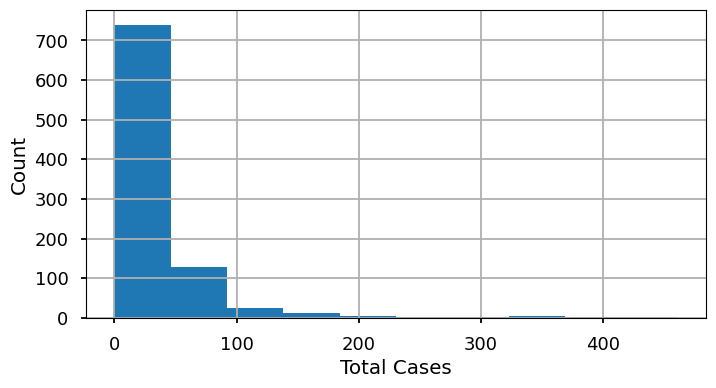

In [12]:
# Check the distribution of the target variable to see if it follows negative binomial distibution.
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(8,4)) 
    train_final.total_cases.hist()
    ax.set_xlabel('Total Cases')
    ax.set_ylabel('Count')
print('mean: ', train_final.total_cases.mean())
print('var :', train_final.total_cases.var())

In [13]:
# create a copy of the train_final for NBR
train_NBR = train_final.copy()
train_NBR.head()

,total_cases,year,weekofyear,month,fall,spring,summer,winter,station_avg_temp_c,station_max_temp_c,...,watery_shift,station_max_temp_c_shift_18,station_min_temp_c_shift_18,station_avg_temp_c_shift_18,reanalysis_tdtr_k_shift_8,reanalysis_specific_humidity_g_per_kg_shift_12,reanalysis_precip_amt_kg_per_m2_shift_8,grassy_shift_20,soily_shift_20,watery_shift_20
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-07-16,2,1990.0,29.0,7,0,0,1,0,28.128571,32.8,...,0.0,32.990000,22.940000,27.584286,2.169643,16.840286,26.65000,0.300000,0.700000,0.0
1990-07-23,6,1990.0,30.0,7,0,0,1,0,28.114286,31.7,...,0.0,32.872727,22.827273,27.581818,2.151786,16.892857,28.85250,0.272727,0.727273,0.0
1990-07-30,17,1990.0,31.0,7,0,0,1,0,28.242857,34.4,...,0.0,32.866667,22.916667,27.627381,2.150000,16.963214,32.22750,0.333333,0.666667,0.0
1990-08-06,23,1990.0,32.0,8,0,0,1,0,28.200000,33.3,...,0.0,32.776923,22.907692,27.664835,2.032143,17.240595,36.01875,0.384615,0.615385,0.0
1990-08-13,13,1990.0,33.0,8,0,0,1,0,28.042857,32.8,...,0.0,32.892857,22.900000,27.706122,2.092857,17.425714,37.03250,0.428571,0.571429,0.0


### Train test split:
* Splitting data into train/test sets is to evaluate under- and overfitting and help to choose the hyperparameters.

In [14]:
# Set the firsy 80% of the data to train, and remaning 20% to test:
train = train_NBR.head(750)
test = train_NBR.tail(train_NBR.shape[0] - 750)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

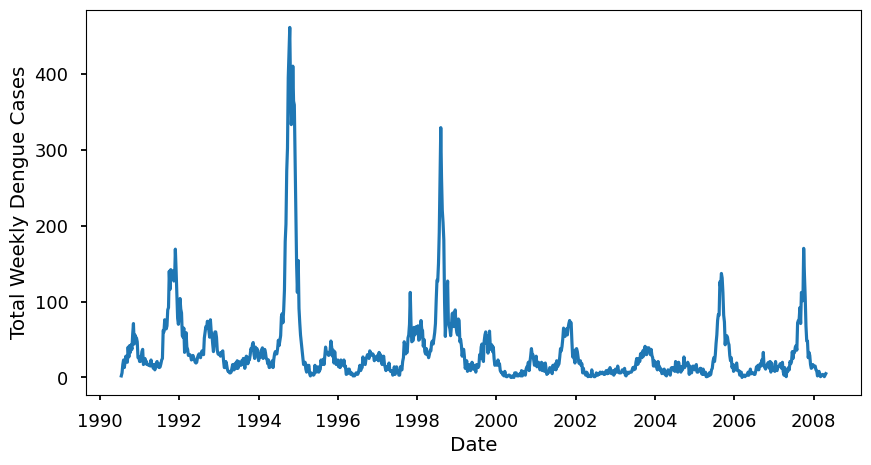

In [15]:
# See the distribution of case counts per each successive year for presentation:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(train_NBR['total_cases'])
    ax.set_xlabel('Date')
    ax.set_ylabel('Total Weekly Dengue Cases')
    fig.patch.set_alpha(0) # make the figure background transparent
    fig.savefig('total_cases_years.png', dpi=300)
    files.download("total_cases_years.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

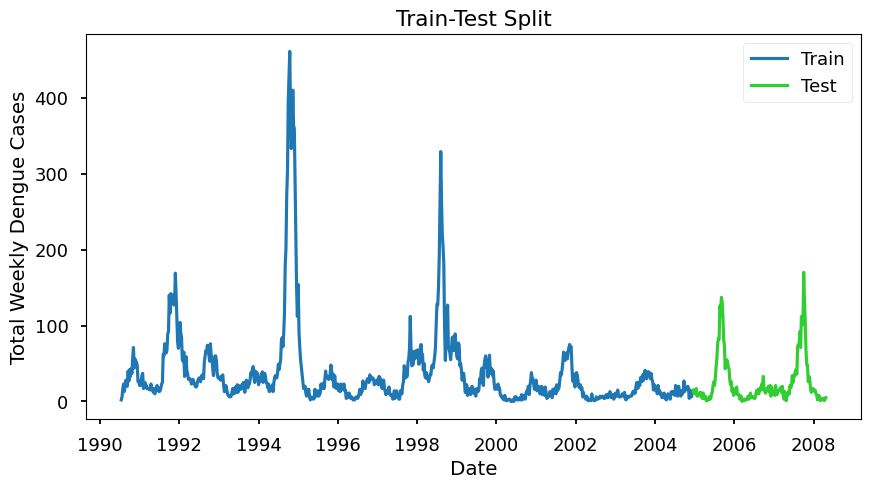

In [16]:
# Plot test-train
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(train['total_cases'], label='Train')
    ax.plot(test['total_cases'], label='Test', color = 'limegreen')
    ax.set_title('Train-Test Split')
    ax.set_xlabel('Date')
    ax.set_ylabel('Total Weekly Dengue Cases')
    fig.patch.set_alpha(0) # make the figure background transparent
    plt.legend();
    fig.savefig('total_cases_test_train_split.png', dpi=300)
    files.download("total_cases_test_train_split.png") 

## Negative Binomial Regression Model #1
* A simple model with 4 original variables.

#### Create a function to:
* to get the best NBR model using the most optimum alpha that minimizes MAE.


In [17]:
def get_best_NBR_model(train, test, model_formula):

    # Create the aplha grid
    grid = np.linspace(0.000001, 2, 1000) # grid = np.arange(-8, -3, dtype=np.float64)
    best_alpha = []
    best_MAE_score = 1000
        
    # Find the best hyper parameter, alpha - specify the regularization distribution between L1 and L2.
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        
        predictions_test = results.predict(test).astype(int)
        score_test = eval_measures.meanabs(predictions_test, test.total_cases)
        
        if score_test < best_MAE_score:
            best_alpha = alpha
            best_MAE_score = score_test
            
    
    print('best alpha = ', best_alpha)
    print('(best) test MAE score = ', best_MAE_score)
    
    # refit on train dataset using best alpha
    model = smf.glm(formula=model_formula,
                    data=train,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))
    fitted_model = model.fit()

    predictions_train = fitted_model.predict(train).astype(int) 
    score_train = eval_measures.meanabs(predictions_train, train.total_cases)
    print('train MAE score = ', score_train)
    
    return fitted_model

In [18]:
# Create the model formula and run above function
model_formula = "total_cases ~ 1 + " \
                "station_avg_temp_c + " \
                "reanalysis_tdtr_k + " \
                "reanalysis_specific_humidity_g_per_kg + " \
                "reanalysis_precip_amt_kg_per_m2  " \

best_model = get_best_NBR_model(train, test, model_formula)
best_model.summary()

best alpha =  1e-06
(best) test MAE score =  22.617142857142856
train MAE score =  29.001333333333335


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  750
Model:                            GLM   Df Residuals:                      745
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17211.
Date:                Tue, 04 Apr 2023   Deviance:                       30782.
Time:                        00:50:34   Pearson chi2:                 5.22e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9669
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.5271      0.146     -3.598      0.000      -0.814      -0.240
station_avg_temp_c                        0.1479      0.010     15.537      0.000       0.129       0.167
reanalysis_tdtr_k                        -0.3015      0.015    -20.405      0.000      -0.330      -0.273
reanalysis_specific_humidity_g_per_kg     0.0472      0.009      5.277      0.000       0.030       0.065
reanalysis_precip_amt_kg_per_m2           0.0014      0.000      9.855      0.000       0.001       0.002
=========================================================================================================
"""

#### Create a function to:
* (1) plot the true total cases against test and train predictions.
* (2) display the Mean Absolute Error and Root Mean Sqaure Error for both train and test. This helps to see the overall performance of the model on both train and test, and assess overfitting. 


In [19]:
def forecast_graph(observed, predictions_train, predictions_test):

    with plt.style.context('seaborn-talk'):
        fig, ax = plt.subplots(figsize=(14,6)) 
        ax.plot(observed, label='observed')
        ax.plot(predictions_train, label='train - fitted') 
        ax.plot(predictions_test, label='test - forecasted') 
        ax.set_title("Dengue Predicted Cases vs. Actual Cases")
        ax.set_xlabel('Date')
        ax.set_ylabel('Total Cases')
        plt.legend(); 

In [20]:
def final_scores(y_train_true, y_train_pred, y_test_true, y_test_pred):
    MAE_train = MAE(y_train_true, y_train_pred)
    MAE_test = MAE( y_test_true, y_test_pred)

    RMSE_train = MSE(y_train_true, y_train_pred, squared=False) # Setting squared to False will return the RMSE.
    RMSE_test = MSE(y_test_true, y_test_pred, squared=False)

    print('MAE_train: %f' % MAE_train)
    print('MAE_test: %f' % MAE_test)
    print('-----------------------')
    print('RMSE_train: %f' % RMSE_train)
    print('RMSE_test: %f' % RMSE_test)

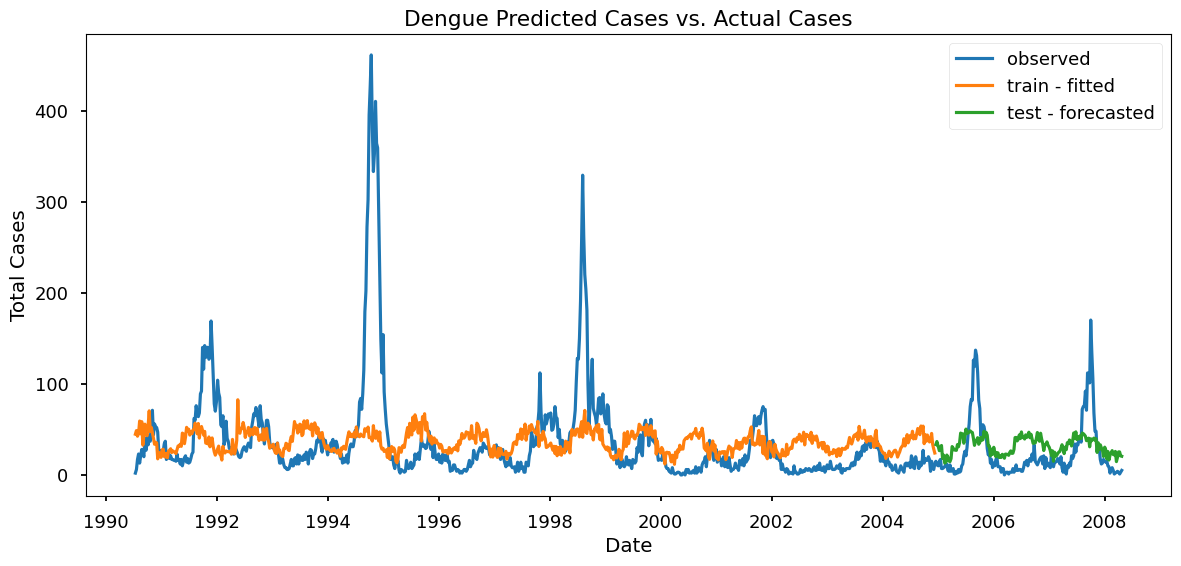

In [21]:
forecast_graph(train_NBR.total_cases, best_model.predict(train), best_model.predict(test))

In [22]:
final_scores(train.total_cases, best_model.predict(train), test.total_cases, best_model.predict(test))

MAE_train: 29.173050
MAE_test: 22.943668
-----------------------
RMSE_train: 53.788695
RMSE_test: 30.244678


**Summary:**

* The model captures the basic seasonality, while missing all the individual ourbreaks - peaks. 

## Negative Binomial Regression Model #2
* Add more variables

In [23]:
model_formula = "total_cases ~ 1 + " \
                "station_avg_temp_c + " \
                "station_max_temp_c + " \
                "station_min_temp_c + " \
                "reanalysis_tdtr_k + " \
                "reanalysis_specific_humidity_g_per_kg + " \
                "reanalysis_precip_amt_kg_per_m2 + " \
                "month "
  
best_model = get_best_NBR_model(train, test, model_formula)
best_model.summary()

best alpha =  1e-06
(best) test MAE score =  21.017142857142858
train MAE score =  28.038666666666668


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  750
Model:                            GLM   Df Residuals:                      742
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15364.
Date:                Tue, 04 Apr 2023   Deviance:                       27086.
Time:                        00:51:07   Pearson chi2:                 4.10e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9998
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.5088      0.152     -3.337      0.001      -0.808      -0.210
station_avg_temp_c                       -0.0797      0.017     -4.633      0.000      -0.113      -0.046
station_max_temp_c                        0.2414      0.008     29.861      0.000       0.226       0.257
station_min_temp_c                       -0.0109      0.011     -1.020      0.308      -0.032       0.010
reanalysis_tdtr_k                        -0.3484      0.015    -22.924      0.000      -0.378      -0.319
reanalysis_specific_humidity_g_per_kg    -0.0725      0.010     -7.462      0.000      -0.092      -0.053
reanalysis_precip_amt_kg_per_m2           0.0008      0.000      4.951      0.000       0.000       0.001
month                                     0.1202      0.002     55.314      0.000       0.116       0.124
=========================================================================================================
"""

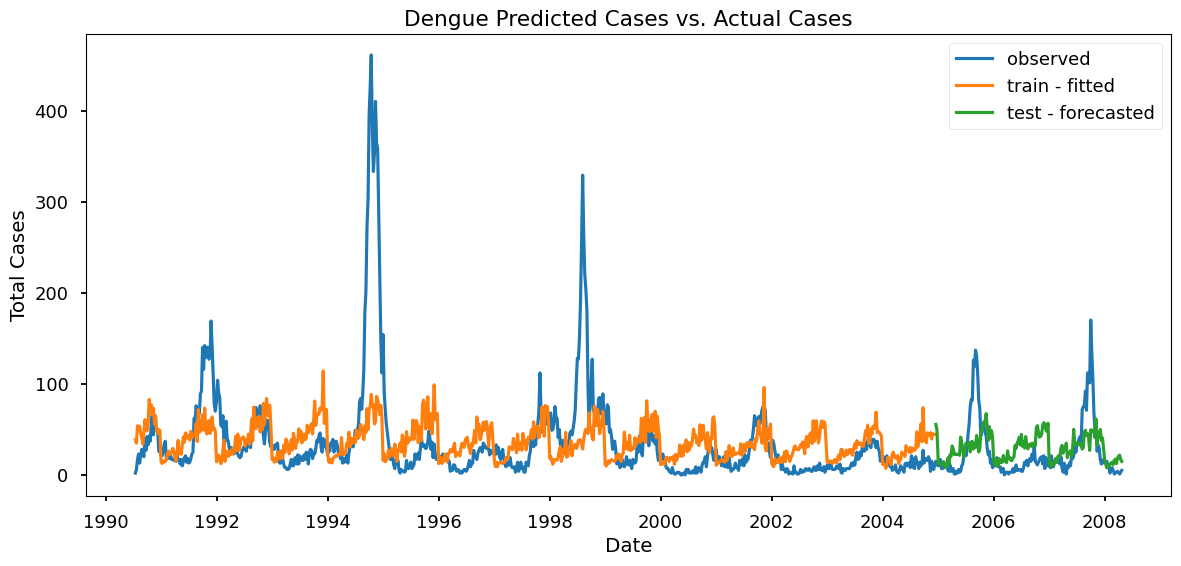

In [24]:
forecast_graph(train_NBR.total_cases, best_model.predict(train), best_model.predict(test))

In [25]:
final_scores(train.total_cases, best_model.predict(train), test.total_cases, best_model.predict(test))

MAE_train: 28.226007
MAE_test: 21.302535
-----------------------
RMSE_train: 51.058028
RMSE_test: 30.007795


**Summary:**

* The model with more variables is a little better as the MAE scores are slightly lower. 
* It still captures the basic seasonality only, while missing all the individual ourbreaks - peaks. 
* There is also some asyncrony between the onset of each predicted peak.

## Negative Binomial Regression Model #3
* Use time shifted variables

In [26]:
model_formula = "total_cases ~ 1 + " \
                "station_max_temp_c_shift + " \
                "station_min_temp_c_shift + " \
                "station_avg_temp_c_shift + " \
                "reanalysis_tdtr_k_shift + " \
                "reanalysis_specific_humidity_g_per_kg_shift + " \
                "reanalysis_precip_amt_kg_per_m2_shift + " \
                "month +" \
                "grassy_shift +" \
                "watery_shift +" \
                "soily_shift" 
    
best_model = get_best_NBR_model(train, test, model_formula)
best_model.summary()

best alpha =  0.0020030010010010013
(best) test MAE score =  20.405714285714286
train MAE score =  27.653333333333332


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  750
Model:                            GLM   Df Residuals:                      740
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13505.
Date:                Tue, 04 Apr 2023   Deviance:                       23319.
Time:                        00:51:43   Pearson chi2:                 3.58e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9998
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -0.6370      0.124     -5.126      0.000      -0.881      -0.393
station_max_temp_c_shift                        0.1841      0.009     21.584      0.000       0.167       0.201
station_min_temp_c_shift                        0.0655      0.011      5.815      0.000       0.043       0.088
station_avg_temp_c_shift                       -0.0418      0.018     -2.274      0.023      -0.078      -0.006
reanalysis_tdtr_k_shift                        -0.4561      0.016    -28.371      0.000      -0.488      -0.425
reanalysis_specific_humidity_g_per_kg_shift    -0.0909      0.010     -8.661      0.000      -0.111      -0.070
reanalysis_precip_amt_kg_per_m2_shift           0.0007      0.000      4.164      0.000       0.000       0.001
month                                           0.0992      0.003     38.799      0.000       0.094       0.104
grassy_shift                                   -0.3490      0.044     -7.863      0.000      -0.436      -0.262
watery_shift                                   -0.2550      0.043     -5.985      0.000      -0.338      -0.171
soily_shift                                    -0.0330      0.044     -0.752      0.452      -0.119       0.053
===============================================================================================================
"""

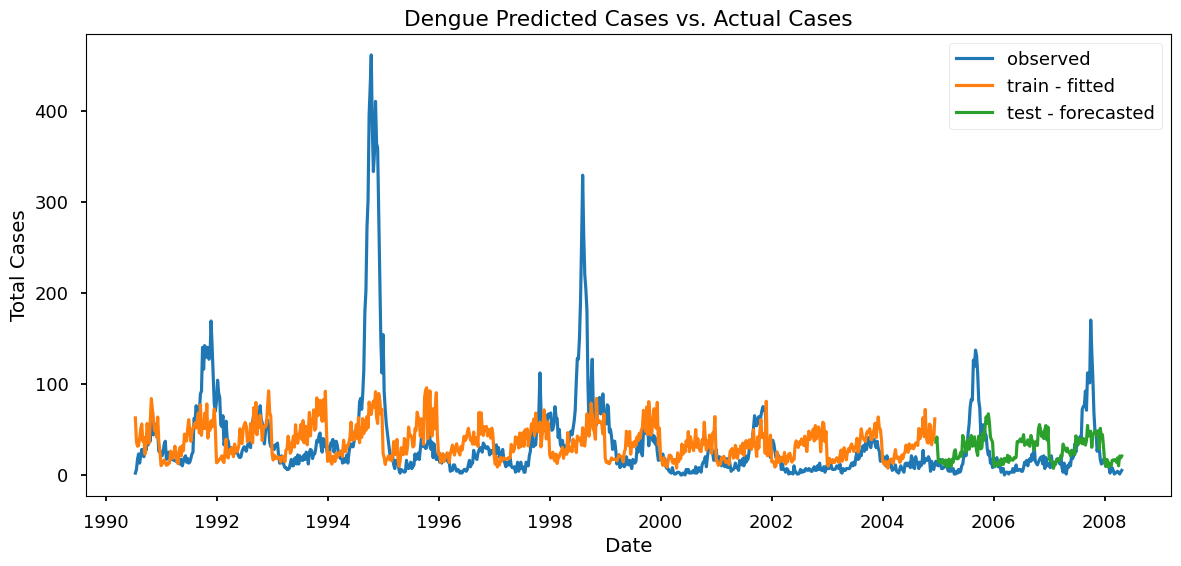

In [27]:
forecast_graph(train_NBR.total_cases, best_model.predict(train), best_model.predict(test))

In [28]:
final_scores(train.total_cases, best_model.predict(train), 
             test.total_cases, best_model.predict(test))

MAE_train: 27.839518
MAE_test: 20.656355
-----------------------
RMSE_train: 50.823396
RMSE_test: 29.647056


**Summary:**

* This model is a little better as the MAE scores are slightly lower. 
* However, it still captures the basic seasonality only, while missing all the individual ourbreaks - peaks. 
* Using time shifted variables did not help much. 

## Negative Binomial Regression Model #4
* Use time sfifted variables with most highly correlated lagged means to account for sustained heat, humidity, precipitation and vegetation. 

In [29]:
model_formula = "total_cases ~ 1 + " \
                "station_max_temp_c_shift_18 + " \
                "station_min_temp_c_shift_18 + " \
                "station_avg_temp_c_shift_18 + " \
                "reanalysis_tdtr_k_shift_8 + " \
                "reanalysis_specific_humidity_g_per_kg_shift_12 + " \
                "reanalysis_precip_amt_kg_per_m2_shift_8 + " \
                "fall +" \
                "spring +" \
                "winter +" \
                "summer +" \
                "grassy_shift_20 +" \
                "soily_shift_20 +" \
                "watery_shift_20" \
    
best_model = get_best_NBR_model(train, test, model_formula)
best_model.summary()

best alpha =  1e-06
(best) test MAE score =  15.771428571428572
train MAE score =  20.158666666666665


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  750
Model:                            GLM   Df Residuals:                      738
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8939.3
Date:                Tue, 04 Apr 2023   Deviance:                       14238.
Time:                        00:52:57   Pearson chi2:                 1.84e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         -9.9703      0.246    -40.590      0.000     -10.452      -9.489
station_max_temp_c_shift_18                        1.4173      0.031     45.622      0.000       1.356       1.478
station_min_temp_c_shift_18                        2.2127      0.038     58.632      0.000       2.139       2.287
station_avg_temp_c_shift_18                       -2.4829      0.062    -40.011      0.000      -2.605      -2.361
reanalysis_tdtr_k_shift_8                         -0.5996      0.028    -21.653      0.000      -0.654      -0.545
reanalysis_specific_humidity_g_per_kg_shift_12    -0.4644      0.016    -29.577      0.000      -0.495      -0.434
reanalysis_precip_amt_kg_per_m2_shift_8           -0.0037      0.000     -8.484      0.000      -0.005      -0.003
fall                                              -2.3035      0.074    -30.927      0.000      -2.449      -2.158
spring                                            -2.5182      0.052    -48.305      0.000      -2.620      -2.416
winter                                            -2.6845      0.067    -40.275      0.000      -2.815      -2.554
summer                                            -2.4641      0.061    -40.504      0.000      -2.583      -2.345
grassy_shift_20                                   -3.4037      0.102    -33.440      0.000      -3.603      -3.204
soily_shift_20                                    -2.4105      0.106    -22.803      0.000      -2.618      -2.203
watery_shift_20                                   -4.1560      0.087    -47.657      0.000      -4.327      -3.985
==================================================================================================================
"""

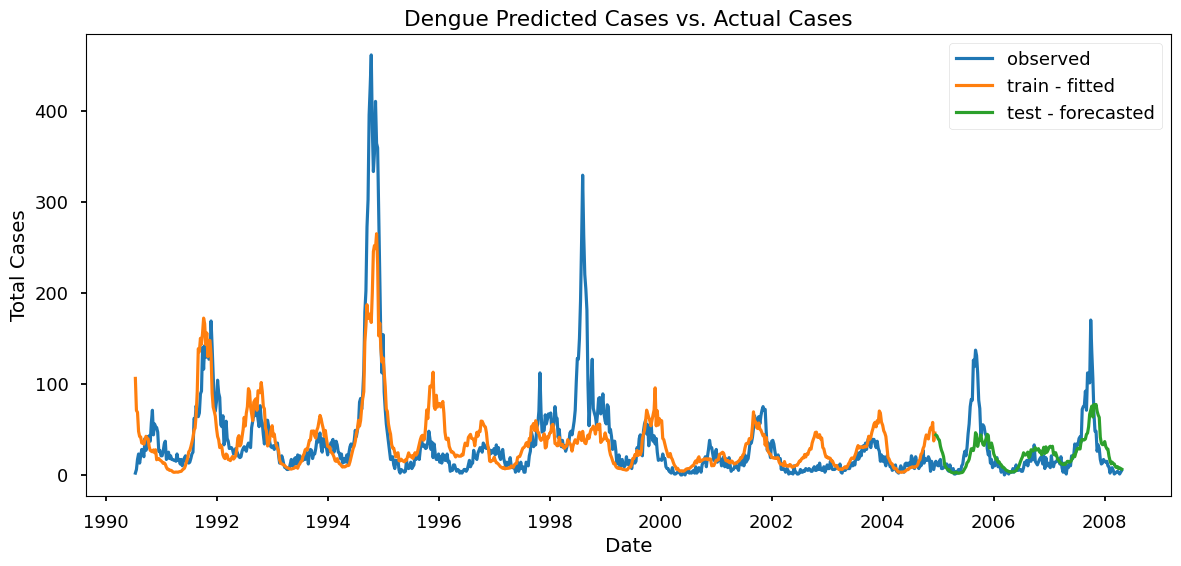

In [30]:
forecast_graph(train_NBR.total_cases, best_model.predict(train), best_model.predict(test))

In [31]:
final_scores(train.total_cases, best_model.predict(train), test.total_cases, best_model.predict(test))

MAE_train: 20.243531
MAE_test: 15.921087
-----------------------
RMSE_train: 36.521933
RMSE_test: 25.074627


**Summary:**

* This model is significantly better as the MAE scores are  lower. 
* This model captures some of the individual peaks-outbreak correctly and it generalizes on to the test set better as well. 

## Retit on the whole dataset for feature importance and forecasting into future :
* Once we have done enough iterations and we are satisfied with the performance, we can retrain your model on the total labeled data. 
* Splitting data into train/test sets is to evaluate under- and overfitting and help us choose the hyperparameters. Once this is achieved, it makes sense to get maximal performance before using your model in real applications.
* Let's see how the model predicts on te final test set, for which we do not have the true case counts available.

In [32]:
# refit on the whole data set to be able to project onto future and extract feature importances
model = smf.glm(formula=model_formula,
                    data=train_NBR,
                    family=sm.families.NegativeBinomial(alpha=1e-06))
fitted_model = model.fit()

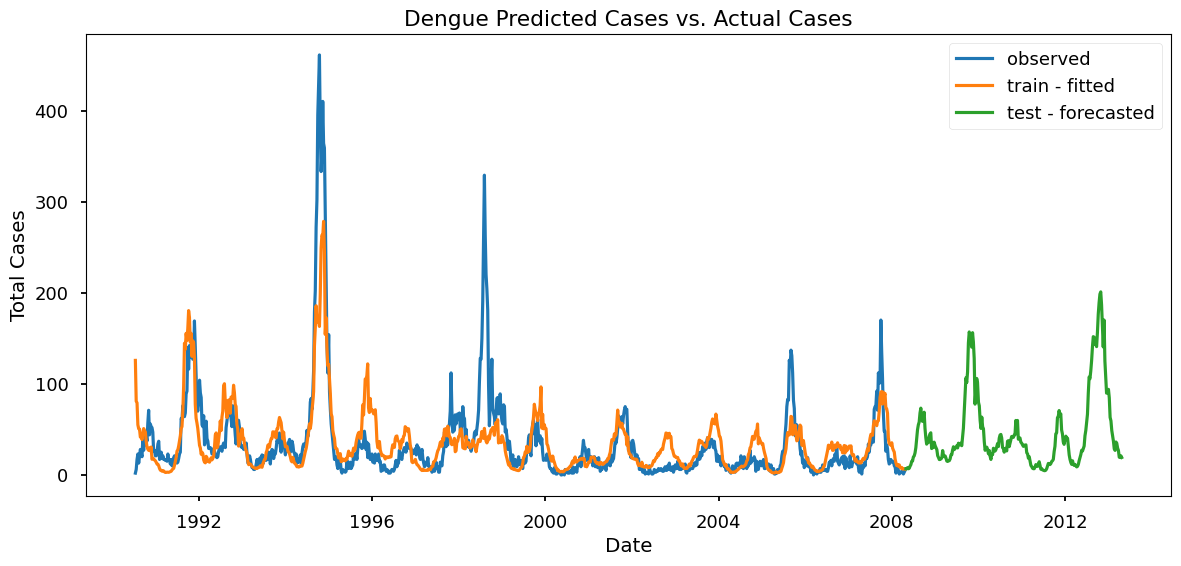

In [33]:
forecast_graph(train_NBR.total_cases, fitted_model.predict(train_NBR), fitted_model.predict(test_final))

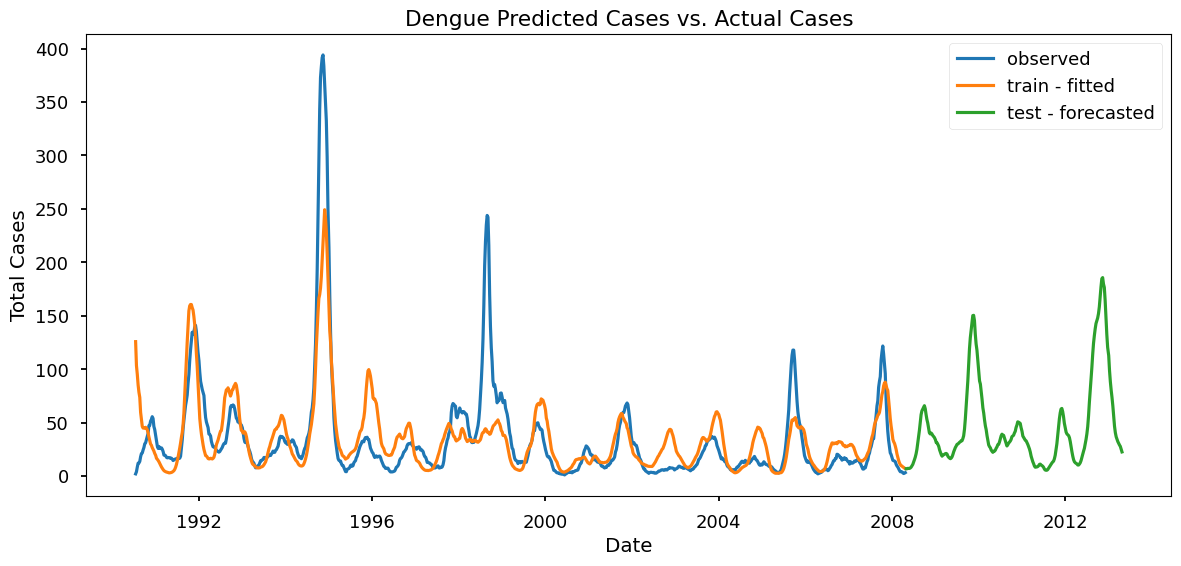

In [34]:
# Create a smoother version of the above graph:
total_cases_rolled = train_NBR.total_cases.rolling(window=6, min_periods = 1).mean()
predicted_train_final_rolled = fitted_model.predict(train_NBR).rolling(window=6, min_periods = 1).mean()
predicted_test_final_rolled = fitted_model.predict(test_final).rolling(window=6, min_periods = 1).mean()

forecast_graph(total_cases_rolled, predicted_train_final_rolled, predicted_test_final_rolled)

### Extract Feature importance from the final model:

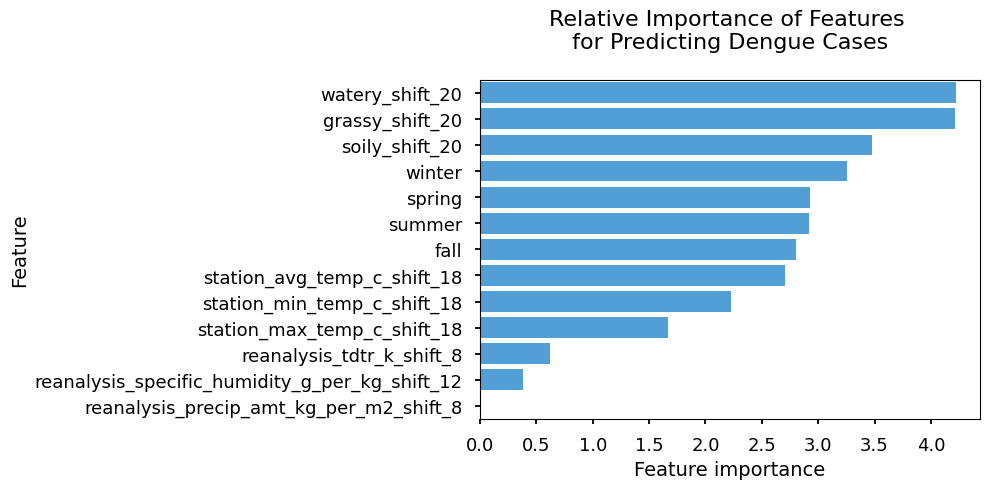

In [35]:
# Drop the model coefficient for graphing purposes:
coeff = fitted_model.params.drop('Intercept')

# Sort the coefficients: 
coeff = coeff.abs().sort_values(ascending=False) # if you want to keep - or +: coeff = coeff.iloc[(coeff.abs()*-1.0).argsort()]
# extract the index representing variable names
feature_names = pd.DataFrame(coeff).index

# Plot the coefficients using a TORNADO PLOT:
with plt.style.context('seaborn-talk'):
    base_color = sns.color_palette("husl", 9)[6]
    fig, ax  = plt.subplots(figsize=(10, 5))
    sns.barplot(x=coeff.values, y=coeff.index, color = base_color, ax=ax, orient='h')
    ax.set_title("Relative Importance of Features \n for Predicting Dengue Cases \n", fontsize=16) 
    ax.set_xlabel("Feature importance", fontsize=14)
    ax.set_ylabel("Feature", fontsize=14)
    ax.set_yticklabels(labels=feature_names)
    fig.tight_layout();  
    # fig.savefig('./images/TornadoPlot_Coefs.png', dpi=300)

* Accorading to Negative Binomial Regression the most important features for predicting dengue cases are the NDVI variables. 

# ARIMA

In [36]:
train_ARIMA = train_final.copy()

### RE-SAMPLE the time series dataset from **weekly** to **monthly**:
* This step was necessary since hyperparameter search with pm.auto_arima did not work efficiently on weekly data. 

In [37]:
train_ARIMA= train_ARIMA.resample('1M').mean()
train_ARIMA
# We are down to 214 rows.

,total_cases,year,weekofyear,month,fall,spring,summer,winter,station_avg_temp_c,station_max_temp_c,...,watery_shift,station_max_temp_c_shift_18,station_min_temp_c_shift_18,station_avg_temp_c_shift_18,reanalysis_tdtr_k_shift_8,reanalysis_specific_humidity_g_per_kg_shift_12,reanalysis_precip_amt_kg_per_m2_shift_8,grassy_shift_20,soily_shift_20,watery_shift_20
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-07-31,8.333333,1990.0,30.0,7.0,0.0,0.0,1.0,0.0,28.161905,32.966667,...,0.00,32.909798,22.894646,27.597828,2.157143,16.898786,29.243333,0.302020,0.697980,0.0000
1990-08-31,21.250000,1990.0,33.5,8.0,0.0,0.0,1.0,0.0,28.310714,32.900000,...,0.00,32.875570,22.913277,27.717010,2.104464,17.463720,37.863438,0.397047,0.602953,0.0000
1990-09-30,27.750000,1990.0,37.5,9.0,1.0,0.0,0.0,0.0,28.400000,33.075000,...,0.00,33.029657,23.124183,27.936006,2.325893,17.863095,41.957500,0.457473,0.542527,0.0000
1990-10-31,42.400000,1990.0,42.0,10.0,1.0,0.0,0.0,0.0,27.954286,32.980000,...,0.00,33.142222,23.448889,28.242063,2.439286,17.999024,46.427500,0.590000,0.410000,0.0000
1990-11-30,56.000000,1990.0,46.5,11.0,1.0,0.0,0.0,0.0,27.253571,32.225000,...,0.00,32.968056,23.409722,28.174603,2.263393,18.081935,78.978750,0.575000,0.425000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-12-31,14.750000,2007.0,50.5,12.0,0.0,0.0,0.0,1.0,25.442857,28.875000,...,0.75,32.277778,23.591667,27.821032,2.646429,17.372321,43.128750,0.050000,0.737500,0.2125
2008-01-31,12.600000,2008.0,3.0,1.0,0.0,0.0,0.0,1.0,24.780000,28.440000,...,0.20,31.272222,23.035556,27.024603,2.438214,16.465048,39.525500,0.030000,0.690000,0.2800
2008-02-29,5.250000,2008.0,7.5,2.0,0.0,0.0,0.0,1.0,24.664286,27.900000,...,0.25,30.031944,22.241667,26.101389,2.435268,15.370804,25.243125,0.000000,0.650000,0.3500


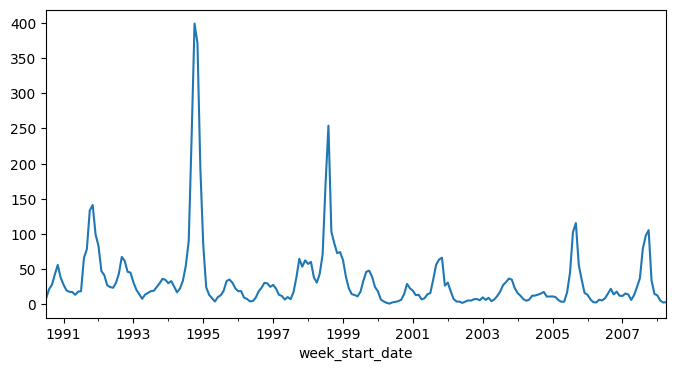

In [38]:
train_ARIMA.total_cases.plot(figsize=(8,4));
# we preserved the same shape

### Plot the ACF (auto correlation function) and PACF (partial auto correlation function):

* Both the ACF and PACF start with a lag of 0, which is the correlation of the time series with itself and results in a correlation of 1.
* The partial autocorrelation function can be interpreted as a regression of the series against its past lags. It helps you come up with a possible order for the auto regressive term.
* To figure out the order of an AR model, you need to look at the PACF.
* To figure out the order of an MA model, you need to look at the ACF.

In [39]:
trainseasonal = train_ARIMA['total_cases']

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


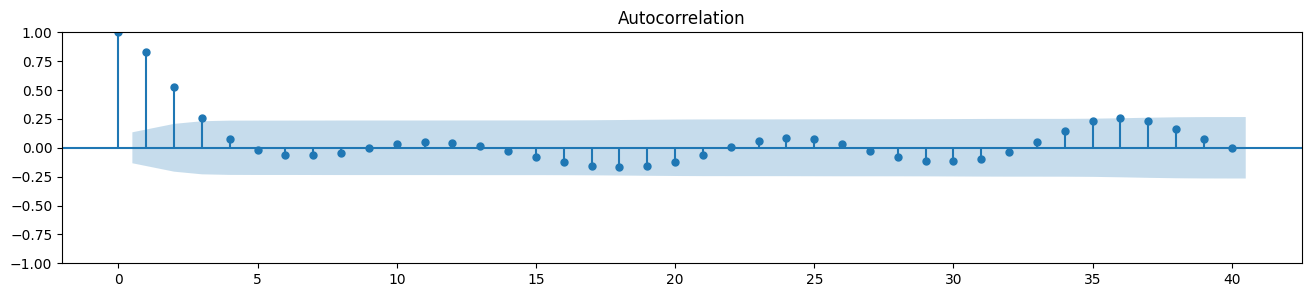

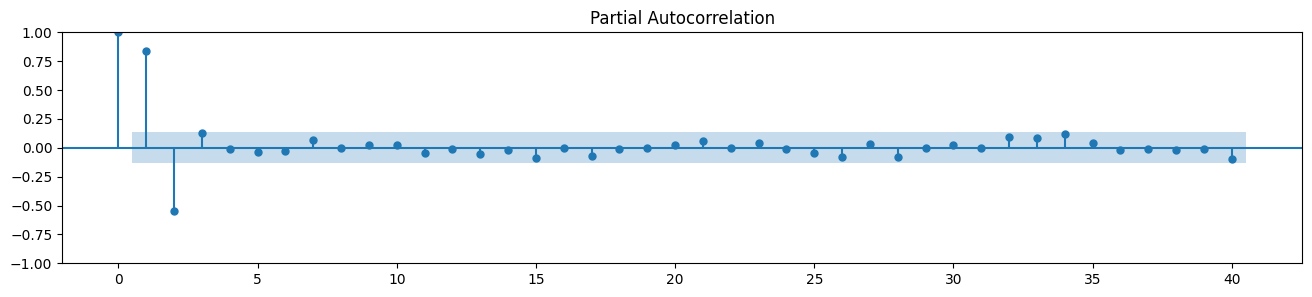

In [40]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(trainseasonal, ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(trainseasonal, ax=ax, lags=40);

* There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.
* High degree of autocorrelation between adjacent (lag = 1) and near-adjacent (lag = 2) observations in both ACF and PACF plots

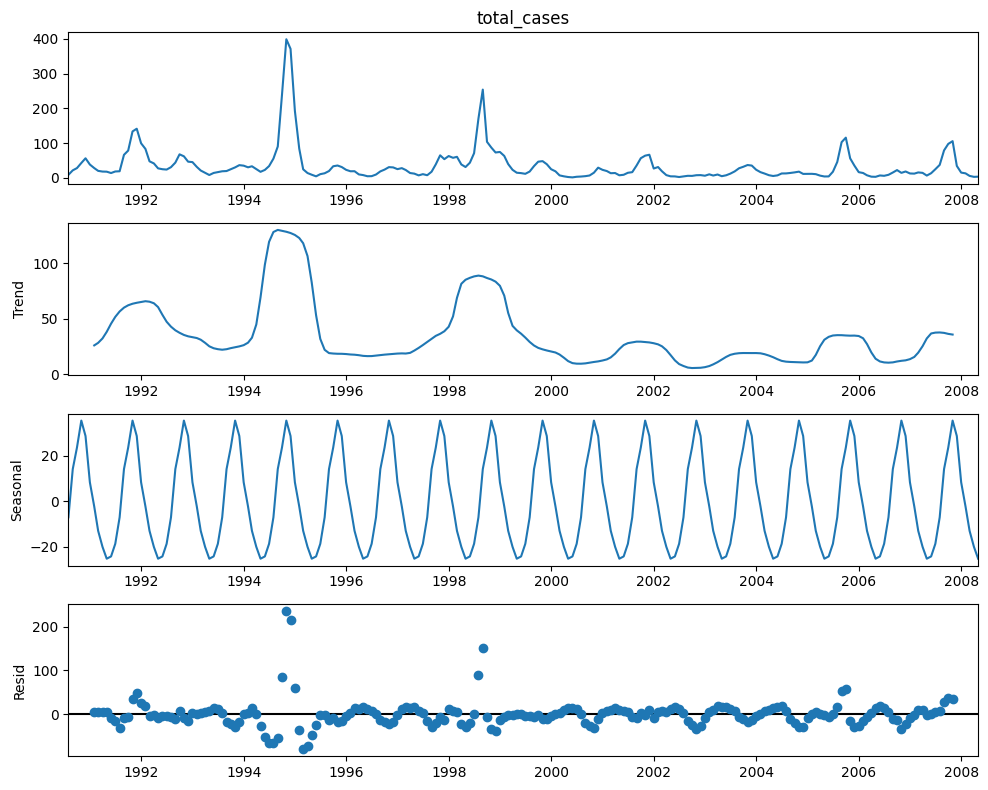

In [41]:
# Plot seasonality and trends:
# Since I’m working with monthly data, setting the frequency to 12 seems logical.
result = seasonal_decompose(trainseasonal, period = 12, model='additive')
fig = result.plot()
fig.set_size_inches((10, 8))
fig.tight_layout()
plt.show()

In [42]:
# Statistical test to see if the time series is stationary or not
adf_test = ADFTest(alpha = .05)
adf_test.should_diff(trainseasonal)

(0.01, False)

* Data is nonstationary! We need to use INtegrated (I) concept. 


# SARIMA #1 Baseline Model:
* Using only total cases as the predictor

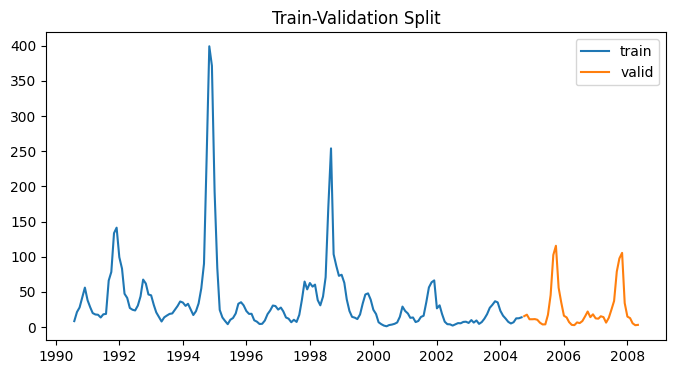

In [43]:
# Test-train split
train = train_ARIMA['total_cases'].head(170)
test = train_ARIMA['total_cases'].tail(train_ARIMA.shape[0] - 170)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(train, label='train')
ax.plot(test, label='valid')
ax.set_title('Train-Validation Split')
plt.legend();

### Parameter Search:

A seasonal ARIMA model is classified as an ARIMA(p,d,q)x(P,D,Q) model,

* **p** = number of autoregressive (AR) terms 
* **d** = number of differences 
* **q** = number of moving average (MA) terms

* **P** = number of seasonal autoregressive (SAR) terms 
* **D** = number of seasonal differences 
* **Q** = number of seasonal moving average (SMA) terms


Using the auto_arima() function from the pmdarima package, we can perform a parameter search for the optimal values of the model.

In [44]:
# Parameter Search
sarimax_best = auto_arima(train,  
                          start_p=1, start_q=1, max_p=5, max_q=5,
                          d=1, D=1,
                          start_P=1, start_Q=1, max_P=5, max_Q=5, 
                          m=12, 
                          max_order=None, 
                          error_action='ignore', 
                          suppress_warnings=True,
                          trace=True, 
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1631.374, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1565.034, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1608.520, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1544.574, Time=0.36 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1545.150, Time=0.75 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=4.83 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1562.275, Time=0.37 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1529.092, Time=0.89 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1547.536, Time=0.59 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=1527.694, Time=1.72 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=1

In [45]:
# Creating adn fitting Final SARIMAX model
Final_model = SARIMAX(train.astype('int'),
                    order=sarimax_best.order,
                    seasonal_order=sarimax_best.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
Final_output = Final_model.fit()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        total_cases   No. Observations:                  170
Model:             SARIMAX(3, 1, 0)x(5, 1, 0, 12)   Log Likelihood                -435.814
Date:                            Tue, 04 Apr 2023   AIC                            889.627
Time:                                    00:55:09   BIC                            912.517
Sample:                                07-31-1990   HQIC                           898.873
                                     - 08-31-2004                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1099      0.095      1.152      0.249      -0.077       0.297
ar.L2         -0.2342      0.116     -2.022      0.043      -0.461      -0.007
ar.L3         -0.1556      0.154     -1.013      0.311      -0.457       0.146
ar.S.L12      -0.6717      0.105     -6.413      0.000      -0.877      -0.466
ar.S.L24      -0.4578      0.139     -3.292      0.001      -0.730      -0.185
ar.S.L36      -0.3404      0.150     -2.266      0.023      -0.635      -0.046
ar.S.L48      -0.2625      0.176     -1.492      0.136      -0.607       0.082
ar.S.L60      -0.1015      0.141     -0.719      0.472      -0.378       0.175
sigma2       623.1333     58.891     10.581      0.000     507.710     738.557
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              1246.41
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                            -1.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

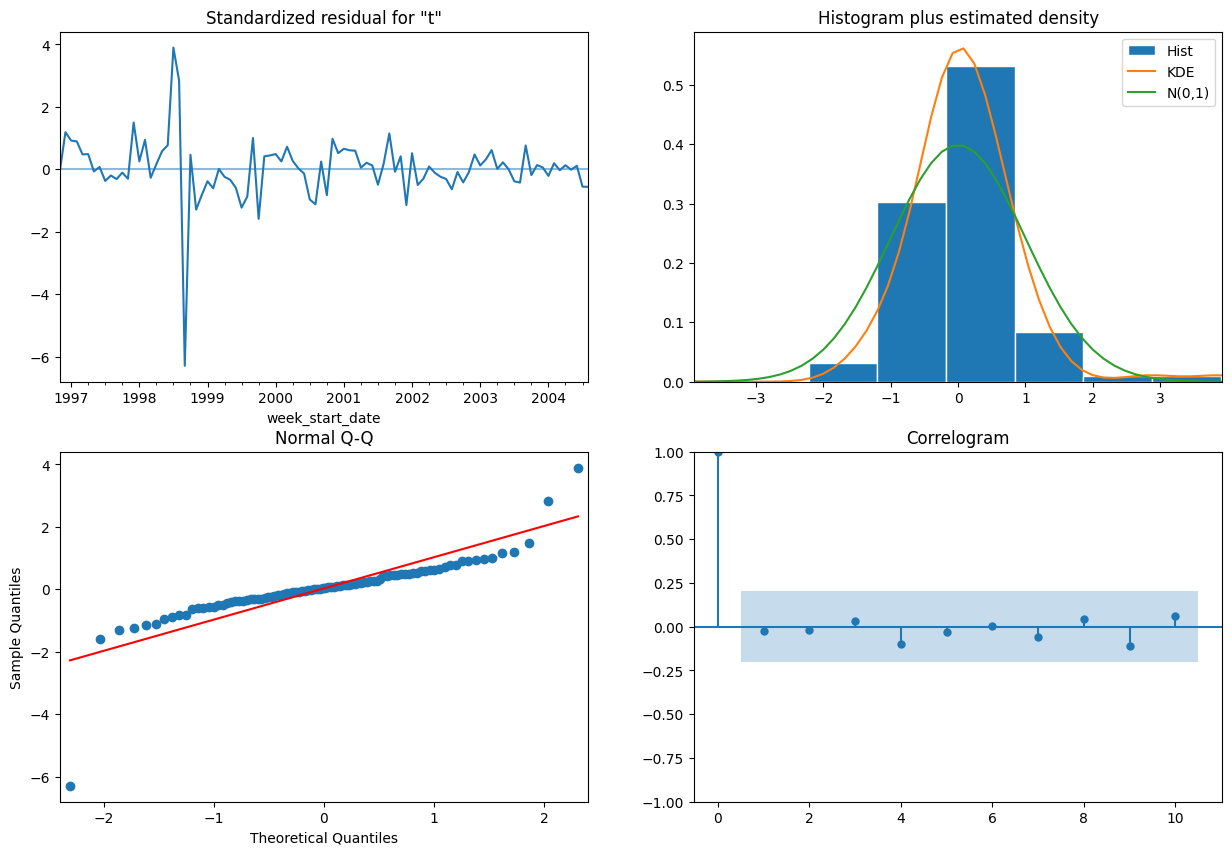

In [46]:
# Displaying the model summary and diagnostics
display(Final_output.summary());
Final_output.plot_diagnostics(figsize=(15, 10));

In [47]:
# Create predictions:
train_prediction =  Final_output.predict(typ='levels') # sari_mod.predict(start=train.index[0], end=train.index[-1]
test_prediction =  Final_output.predict(start=test.index[0], end=test.index[-1],typ='levels')

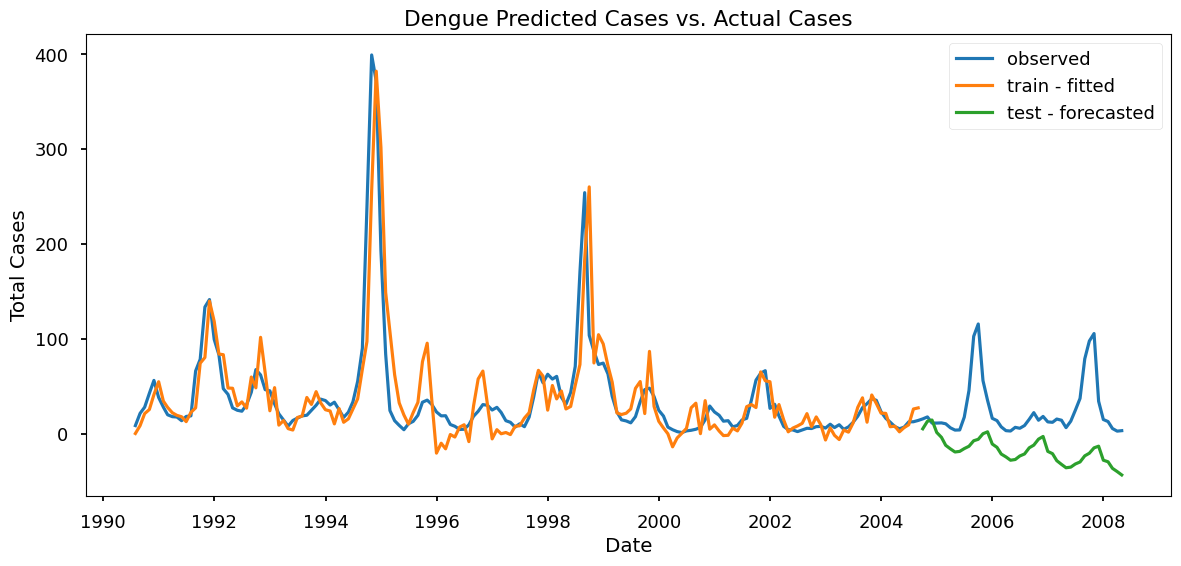

In [48]:
forecast_graph(train_ARIMA.total_cases, train_prediction, test_prediction)

In [49]:
final_scores(train, train_prediction, test, test_prediction)

MAE_train: 17.485334
MAE_test: 42.321119
-----------------------
RMSE_train: 29.872551
RMSE_test: 51.515279


**Summary:**

* Basic Sarima overfits the data. It fits to the train data almost perfectly while performing very poorly for the test set. 

# SARIMAX #2 Full Multivariate Model:
* Using exogenous variables

In [50]:
train_ARIMA2 =  train_ARIMA[['total_cases', 'month', 'station_max_temp_c_shift_18',
                              'station_min_temp_c_shift_18', 'station_avg_temp_c_shift_18',
                              'reanalysis_tdtr_k_shift_8',
                              'reanalysis_specific_humidity_g_per_kg_shift_12',
                              'reanalysis_precip_amt_kg_per_m2_shift_8', 'grassy_shift_20',
                              'soily_shift_20', 'watery_shift_20']]

In [51]:
train_ARIMA2 =  train_ARIMA[['total_cases', 'month', 'station_max_temp_c',
                              'station_min_temp_c', 'station_avg_temp_c',
                              'reanalysis_tdtr_k',
                              'reanalysis_specific_humidity_g_per_kg',
                              'reanalysis_precip_amt_kg_per_m2', 'grassy',
                              'soily', 'watery']]

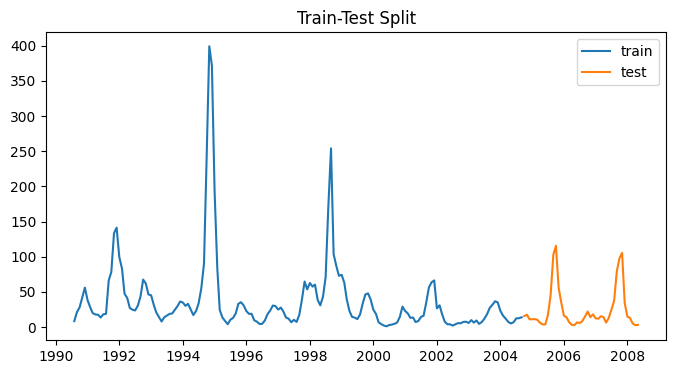

In [52]:
train = train_ARIMA2.head(170)
test = train_ARIMA2.tail(train_ARIMA2.shape[0] - 170)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(train.total_cases, label='train')
ax.plot(test.total_cases, label='test')
ax.set_title('Train-Test Split')
plt.legend();

In [53]:
X_train, y_train, = train.drop('total_cases', axis=1), train['total_cases']
X_test, y_test = test.drop('total_cases', axis=1), test['total_cases']

In [54]:
exog_varbls =  ['month', 'station_max_temp_c',
                'station_min_temp_c', 'station_avg_temp_c',
                'reanalysis_tdtr_k',
                'reanalysis_specific_humidity_g_per_kg',
                'reanalysis_precip_amt_kg_per_m2', 'grassy',
                'soily', 'watery']


In [55]:
endog_train = y_train
endog_test = y_test

In [56]:
list(range(0,10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

### Reshape X_train and X_test into an array of exogenous regressors, shaped nobs x k:

In [57]:
exog_train = np.empty([len(X_train), len(exog_varbls)])
for i, var in zip(list(range(0,len(X_train))), exog_varbls):
    exog_train[:,i] = np.array(X_train[var])

In [58]:
exog_test = np.empty([len(X_test), len(exog_varbls)])
for i, var in zip(list(range(0,len(X_test))), exog_varbls):
    exog_test[:,i] = np.array(X_test[var])

In [59]:
exog_train.shape, exog_test.shape

((170, 10), (44, 10))

In [60]:
# Parameter Search
sarimax_best = auto_arima(y = endog_train, # target
                          X = exog_train,  # external predictors    
                          start_p=1, start_q=1, max_p=5, max_q=5,
                          d=1, D=1,
                          start_P=1, start_Q=1, max_P=5, max_Q=5, 
                          m=12, 
                          max_order=None, 
                          error_action='ignore', 
                          suppress_warnings=True,
                          trace=True, 
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=5.09 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1648.917, Time=0.34 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1583.431, Time=2.54 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.00 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1623.953, Time=0.79 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1562.388, Time=6.69 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1562.936, Time=10.40 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.13 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.05 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=11.65 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1580.987, Time=6.23 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1542.558, Time=6.59 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1564.400, Time=4.18 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=1540.180, Time=12.70 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AI

In [61]:
# Creating Final SARIMAX model
Final_model = SARIMAX(endog = endog_train,
                      exog = exog_train,
                      order=sarimax_best.order,
                      seasonal_order=sarimax_best.seasonal_order,
                      enforce_invertibility=False,
                      enforce_stationarity=False)
Final_output = Final_model.fit()


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        total_cases   No. Observations:                  170
Model:             SARIMAX(3, 1, 0)x(4, 1, 0, 12)   Log Likelihood                -488.362
Date:                            Tue, 04 Apr 2023   AIC                           1012.724
Time:                                    01:03:04   BIC                           1060.666
Sample:                                07-31-1990   HQIC                          1032.155
                                     - 08-31-2004                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -7.875e-08        nan        nan        nan         nan         nan
x2            -2.0536      9.742     -0.211      0.833     -21.147      17.040
x3            -3.7804     12.941     -0.292      0.770     -29.144      21.584
x4             6.5039     19.119      0.340      0.734     -30.969      43.977
x5            11.4327     12.614      0.906      0.365     -13.290      36.156
x6             1.0381     11.378      0.091      0.927     -21.262      23.338
x7             0.0634      0.249      0.255      0.799      -0.424       0.551
x8             0.3277     10.211      0.032      0.974     -19.685      20.340
x9             0.7087      7.224      0.098      0.922     -13.451      14.868
x10           -1.0364     10.535     -0.098      0.922     -21.685      19.612
ar.L1          0.1991      0.092      2.168      0.030       0.019       0.379
ar.L2         -0.2849      0.100     -2.837      0.005      -0.482      -0.088
ar.L3         -0.1801      0.150     -1.204      0.229      -0.473       0.113
ar.S.L12      -0.7319      0.102     -7.199      0.000      -0.931      -0.533
ar.S.L24      -0.5634      0.126     -4.460      0.000      -0.811      -0.316
ar.S.L36      -0.3521      0.123     -2.870      0.004      -0.593      -0.112
ar.S.L48      -0.1959      0.087     -2.244      0.025      -0.367      -0.025
sigma2       587.8307     70.413      8.348      0.000     449.824     725.838
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              1614.41
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                            -2.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.05e+27. Standard errors may be unstable.
"""

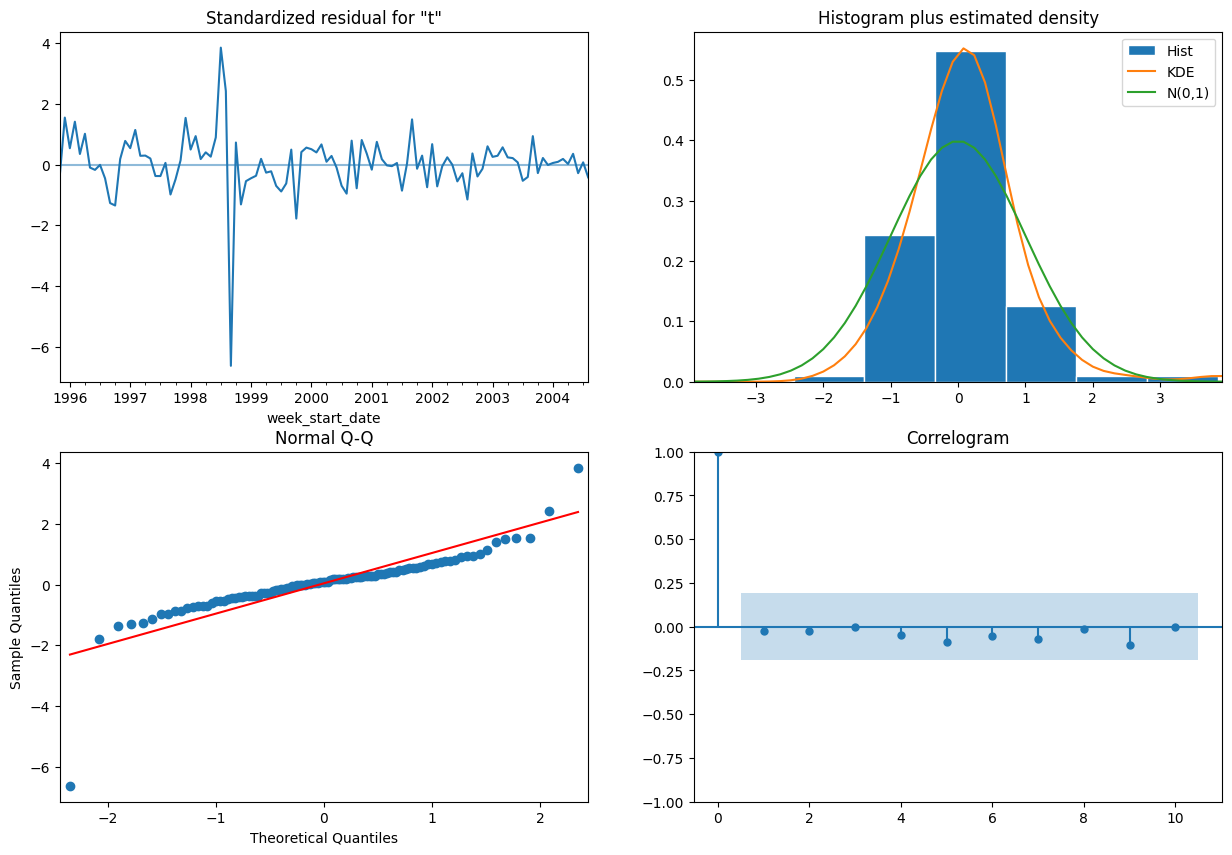

In [62]:
# Displaying the model summary and diagnostics
display(Final_output.summary());
Final_output.plot_diagnostics(figsize=(15, 10));

In [63]:
# Create Predictions:
train_prediction =  Final_output.predict(typ='levels', exog=exog_train) # sari_mod.predict(start=train.index[0], end=train.index[-1]
test_prediction =  Final_output.predict(start=test.index[0], end=test.index[-1],typ='levels', exog=exog_test)

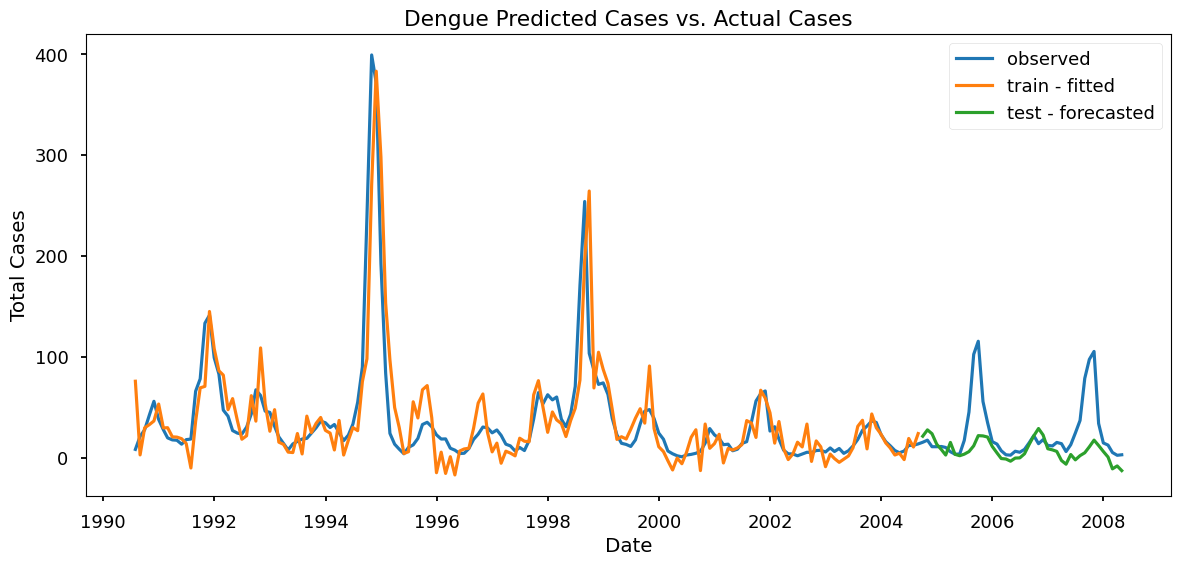

In [64]:
forecast_graph(train_ARIMA.total_cases, train_prediction, test_prediction)

In [65]:
final_scores(train.total_cases, train_prediction, test.total_cases, test_prediction)

MAE_train: 17.613395
MAE_test: 19.492662
-----------------------
RMSE_train: 29.499109
RMSE_test: 32.196027


**Summary:**

* Multivariate Sarima performs better than the basic sarima. However it still does not capture the two peaks in the test dataset. 

# XGB Regression Model #1:
* using original variables

In [66]:
# Re-assign a new dataset called train_XGB
train_XGB = train_final.copy()

In [67]:
# Create a subset of the dataset to use in modeling:
train_XGB1 = train_XGB[['total_cases', 
                        'month', 
                        'station_avg_temp_c', 'station_min_temp_c',
                        'station_max_temp_c', 'reanalysis_tdtr_k',
                        'reanalysis_specific_humidity_g_per_kg',
                        'reanalysis_precip_amt_kg_per_m2',
                        'grassy', 'soily', 'watery']]

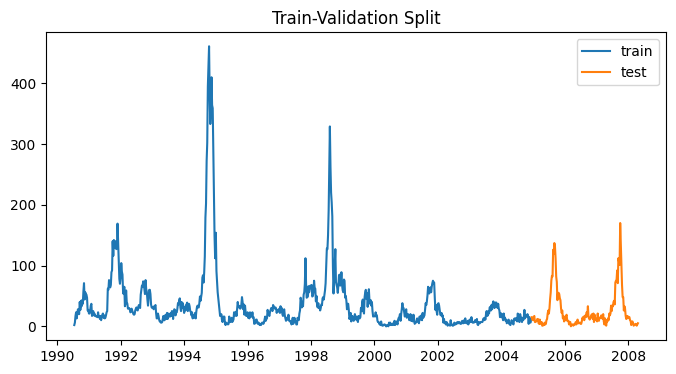

In [68]:
# Test-train split the dataset:
train = train_XGB1.head(750)
test = train_XGB1.tail(train_XGB1.shape[0] - 750)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(train.total_cases, label='train')
ax.plot(test.total_cases, label='test')
ax.set_title('Train-Validation Split')
plt.legend();

In [69]:
X_train, y_train, = train.drop('total_cases', axis=1), train['total_cases']
X_test, y_test = test.drop('total_cases', axis=1), test['total_cases']

In [70]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((750, 10), (750,), (175, 10), (175,))

In [71]:
# time split the dataset into 5 folds to be used in cross validation
time_split = TimeSeriesSplit(n_splits=5)
[(el[0].shape, el[1].shape) for el in time_split.split(X_train)]

[((125,), (125,)),
 ((250,), (125,)),
 ((375,), (125,)),
 ((500,), (125,)),
 ((625,), (125,))]

In [72]:
# initiate the regressor
model = xgb.XGBRegressor()

# Specify the tunable parameters
parameters = {'objective':['reg:squarederror','reg:absoluteerror','reg:squaredlogerror'],  # 'count:poisson'
              'learning_rate':[0.01, 0.05, 0.1, 0.2],   # default = 0.3, Lower ratios avoid over-fitting. 
              'max_depth': [2, 4, 6, 8],                # default = 6, Lower values avoid over-fitting.
              'min_child_weight': [1, 2, 3, 4],         # default = 1, Larger values avoid over-fitting. 
              'gamma':[0.5, 1],                         # default = 0, Larger values avoid over-fitting.
              'colsample_bytree':[0.5, 0.75],           # default = 1, Lower ratios avoid over-fitting.
              'subsample':[0.5, 0.75, 1]}               # default = 1, Lower ratios avoid over-fitting.

# Configure the GridSearchCV object to choose the best hyperparameters 
# Using the neg_mean_squared_error metric to compare the results of 5-fold cross-validation

xgb_grid = GridSearchCV(estimator = model,
                        cv = time_split,
                        param_grid = parameters,
                        scoring = 'neg_mean_squared_error', #eval_metric='logloss'
                        verbose=0)

# Train the best model
xgb_grid.fit(X_train, y_train)

# Print best parameters and best score
print("Best parameters:", xgb_grid.best_params_)
print("Best Score (MAE): ", (xgb_grid.best_score_))


Best parameters: {'colsample_bytree': 0.75, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 1, 'objective': 'reg:absoluteerror', 'subsample': 0.75}
Best Score (MAE):  -3116.6840740212792


In [73]:
# Create the train and test predictions as a DataFrame with index to use on the graph. 
# The best_estimator_ field contains the best model trained by GridSearch.
predicted_train = pd.DataFrame(xgb_grid.best_estimator_.predict(X_train), index= X_train.index)
predicted_test = pd.DataFrame(xgb_grid.best_estimator_.predict(X_test), index= X_test.index)

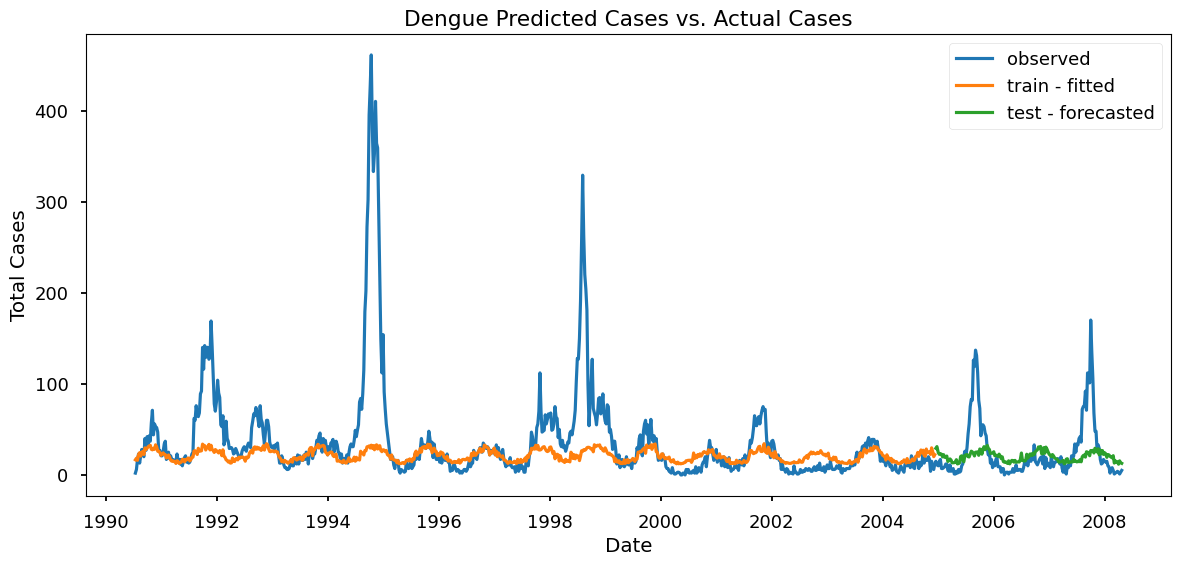

In [74]:
forecast_graph(train_XGB.total_cases, predicted_train, predicted_test)

In [75]:
# Print the scores for both train and test
final_scores(train.total_cases, xgb_grid.best_estimator_.predict(X_train), 
             test.total_cases, xgb_grid.best_estimator_.predict(X_test))

MAE_train: 22.316101
MAE_test: 18.996592
-----------------------
RMSE_train: 54.488551
RMSE_test: 30.858615


**Summary:**

* The model only captures seasonality, and does not capture and of the individual peaks-outbreaks.

## Model #2 using the lagged variables:

In [76]:
train_XGB2 = train_XGB[['total_cases', 'month',
                        'station_avg_temp_c_shift_18', 'station_min_temp_c_shift_18',
                        'station_max_temp_c_shift_18', 'reanalysis_tdtr_k_shift_8',
                        'reanalysis_specific_humidity_g_per_kg_shift_12',
                        'reanalysis_precip_amt_kg_per_m2_shift_8',
                        'grassy_shift_20',
                        'soily_shift_20',
                        'watery_shift_20']]

In [77]:
train = train_XGB2.head(750)
test = train_XGB2.tail(train_XGB2.shape[0] - 750)

In [78]:
X_train, y_train, = train.drop('total_cases', axis=1), train['total_cases']
X_test, y_test = test.drop('total_cases', axis=1), test['total_cases']

In [79]:
time_split = TimeSeriesSplit(n_splits=5)
[(el[0].shape, el[1].shape) for el in time_split.split(X_train)]

[((125,), (125,)),
 ((250,), (125,)),
 ((375,), (125,)),
 ((500,), (125,)),
 ((625,), (125,))]

In [80]:
model = xgb.XGBRegressor()

# Specify the tunable parameters
parameters = {'objective':['reg:squarederror','reg:absoluteerror','reg:squaredlogerror'],  # 'count:poisson'
              'learning_rate':[0.01, 0.05, 0.1, 0.2],   # default = 0.3, Lower ratios avoid over-fitting. 
              'max_depth': [2, 4, 6, 8],                # default = 6, Lower values avoid over-fitting.
              'min_child_weight': [1, 2, 3, 4],         # default = 1, Larger values avoid over-fitting. 
              'gamma':[0.5, 1],                         # default = 0, Larger values avoid over-fitting.
              'colsample_bytree':[0.5, 0.75],           # default = 1, Lower ratios avoid over-fitting.
              'subsample':[0.5, 0.75, 1]}               # default = 1, Lower ratios avoid over-fitting.

# Configure the GridSearchCV object to choose the best hyperparameters 
# using the neg_mean_squared_error metric to compare the results of 5-fold cross-validation

xgb_grid = GridSearchCV(estimator = model,
                        cv = time_split,
                        param_grid = parameters,
                        scoring = 'neg_mean_squared_error', #eval_metric='logloss'
                        verbose=0)

# Train the best model
xgb_grid.fit(X_train, y_train)

# Print best parameters and best score
print("Best parameters:", xgb_grid.best_params_)
print("Best Score (MAE): ", (xgb_grid.best_score_))

Best parameters: {'colsample_bytree': 0.75, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 3, 'objective': 'reg:squarederror', 'subsample': 0.5}
Best Score (MAE):  -2608.85466896299


In [81]:
# Create the train and test predictions as a DataFrame with index to use on the graph. 
predicted_train = pd.DataFrame(xgb_grid.best_estimator_.predict(X_train), columns= ['pred'], index= X_train.index)
predicted_test = pd.DataFrame(xgb_grid.best_estimator_.predict(X_test),columns= ['pred'], index= X_test.index)

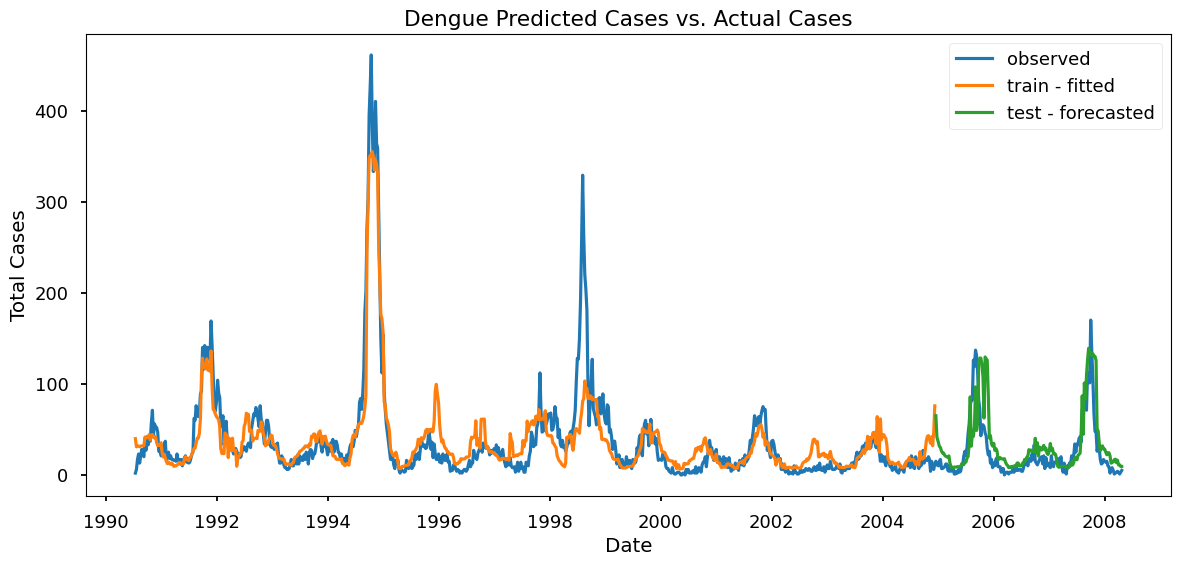

In [82]:
forecast_graph(train_XGB.total_cases, predicted_train, predicted_test)

In [83]:
# Print the scores for both train and test
final_scores(train.total_cases, xgb_grid.best_estimator_.predict(X_train), 
             test.total_cases, xgb_grid.best_estimator_.predict(X_test))

MAE_train: 14.660013
MAE_test: 17.724193
-----------------------
RMSE_train: 24.794945
RMSE_test: 26.477244


In [84]:
# re-create the graph with smooth lines
total_cases_rolled = train_XGB.total_cases.rolling(window=4, min_periods = 1).mean()
predicted_train_rolled = predicted_train['pred'].rolling(window=4, min_periods = 1).mean()
predicted_test_rolled = predicted_test['pred'].rolling(window=4, min_periods = 1).mean()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

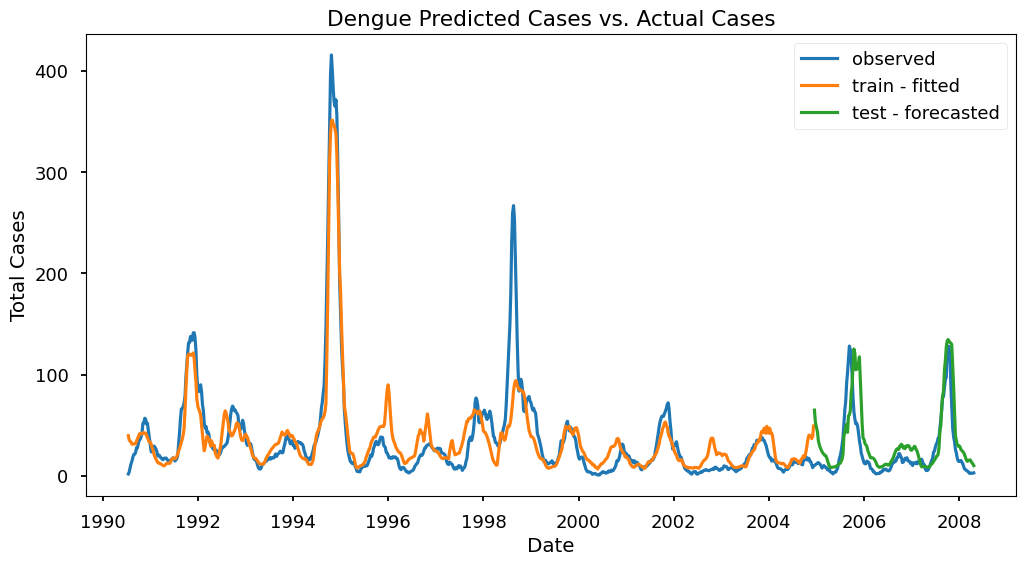

In [85]:
with plt.style.context('seaborn-talk'):
  fig, ax = plt.subplots(figsize=(12,6)) 
  ax.plot(total_cases_rolled, label='observed')
  ax.plot(predicted_train_rolled, label='train - fitted') 
  ax.plot(predicted_test_rolled, label='test - forecasted') 
  ax.set_title("Dengue Predicted Cases vs. Actual Cases")
  ax.set_xlabel('Date')
  ax.set_ylabel('Total Cases')
  ax.xaxis.set_major_locator(mdates.YearLocator(2)) # Set the years on X axis apart by 2
  plt.legend()
  fig.patch.set_alpha(0) # make the figure background transparent
  # plt.tight_layout();
  fig.savefig('XGB_Predict.png', dpi=300, bbox_inches='tight')
  files.download("XGB_Predict.png")  

## Best performing model so far:
**Summary:**
* This model is by far the best model so far. It captures not only seasonality but also individual peaks. 
* It performs equally well for train and test, and generalizes well to unseen data. 

## Refit on the whole dataset:

* Once we have done enough iterations and we are satisfied with the performance, we can retrain your model on the total labeled data to:
  - get maximal performance for forecasting into the future.
  - extract feature importances. 

In [86]:
# re-create X,y train:
X_train_whole, y_train_whole = train_XGB2.drop('total_cases', axis=1), train_XGB2['total_cases']

In [87]:
# get the same features out for test_final
X_test_final = test_final[['month', 
                        'station_avg_temp_c_shift_18', 'station_min_temp_c_shift_18',
                        'station_max_temp_c_shift_18', 'reanalysis_tdtr_k_shift_8',
                        'reanalysis_specific_humidity_g_per_kg_shift_12',
                        'reanalysis_precip_amt_kg_per_m2_shift_8',
                        'grassy_shift_20',
                        'soily_shift_20',
                        'watery_shift_20']]

In [88]:
# Refit to the whole dataset using the best parameters:
model = xgb.XGBRegressor(objective='reg:squarederror',
                         learning_rate=0.05,
                         max_depth=2,
                         min_child_weight= 3,
                         subsample= 0.5,
                         colsample_bytree= 0.75, 
                         gamma= 0.5)

#Creating the model on Training Data
final_model = model.fit(X_train_whole,y_train_whole)

In [89]:
# Create predictions:
predicted_train_final = pd.DataFrame(final_model.predict(X_train_whole), columns= ['pred'], index= X_train_whole.index)
predicted_test_final = pd.DataFrame(final_model.predict(X_test_final), columns= ['pred'],  index= test_final.index)

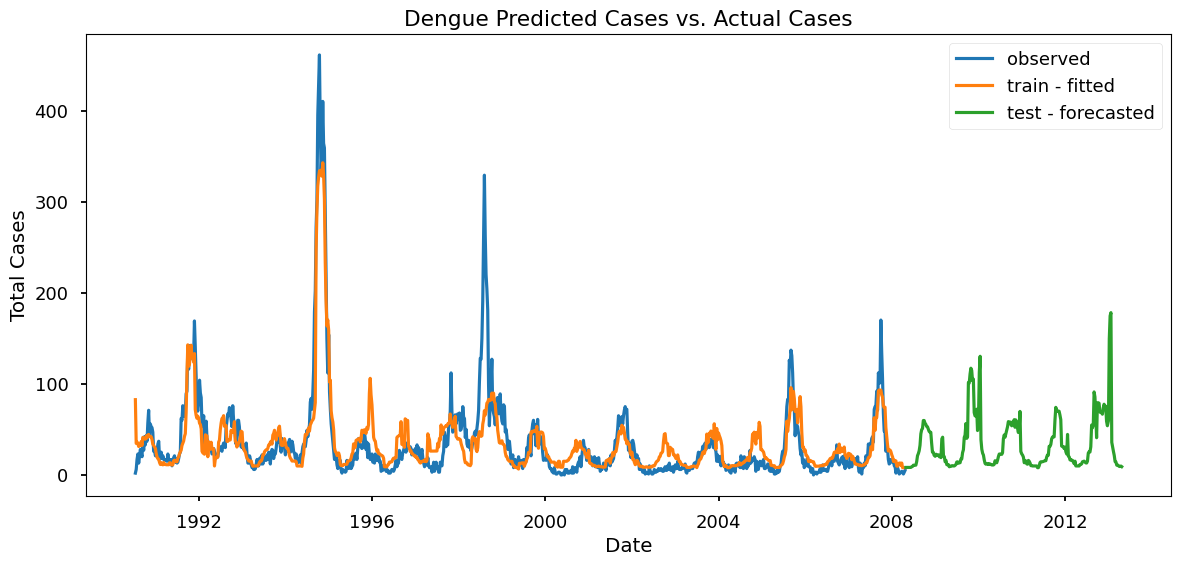

In [90]:
forecast_graph(train_XGB.total_cases, predicted_train_final, predicted_test_final)

In [91]:
# re-create the graph with smooth lines
total_cases_rolled = train_XGB.total_cases.rolling(window=4, min_periods = 1).mean()
predicted_train_final_rolled = predicted_train_final['pred'].rolling(window=4, min_periods = 1).mean()
predicted_test_final_rolled = predicted_test_final['pred'].rolling(window=4, min_periods = 1).mean()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

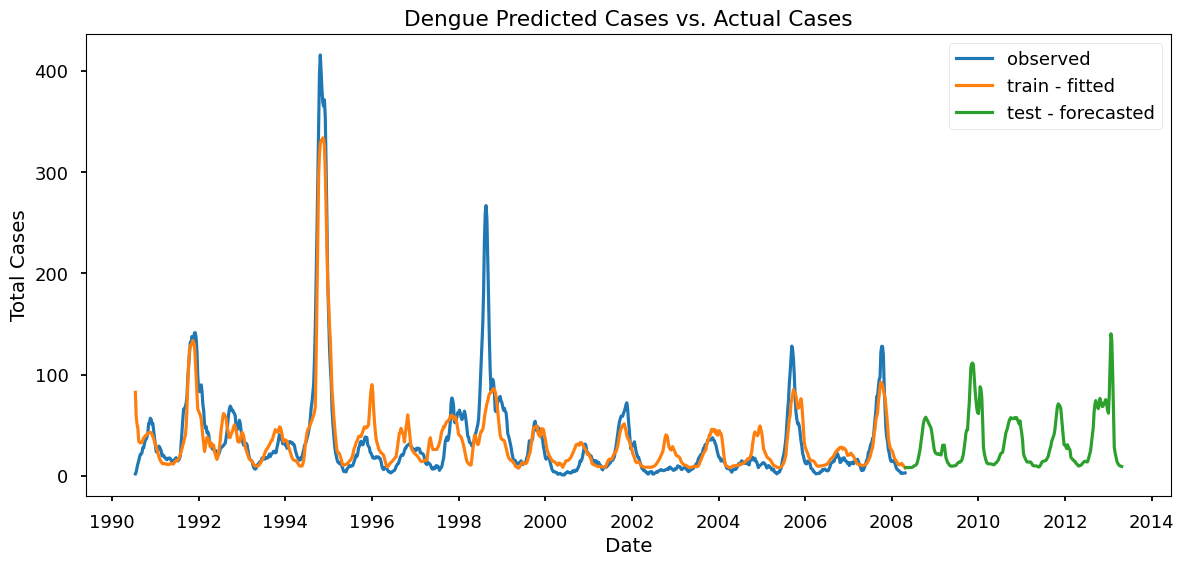

In [92]:
with plt.style.context('seaborn-talk'):
  fig, ax = plt.subplots(figsize=(14,6)) 
  ax.plot(total_cases_rolled, label='observed')
  ax.plot(predicted_train_final_rolled, label='train - fitted') 
  ax.plot(predicted_test_final_rolled, label='test - forecasted') 
  ax.set_title("Dengue Predicted Cases vs. Actual Cases")
  ax.set_xlabel('Date')
  ax.set_ylabel('Total Cases')
  ax.xaxis.set_major_locator(mdates.YearLocator(2)) # Set the years on X axis apart by 2
  plt.legend()
  fig.patch.set_alpha(0) # make the figure background transparent
  # plt.tight_layout();
  fig.savefig('XGB_Forecast.png', dpi=300, bbox_inches='tight')
  files.download("XGB_Forecast.png")       

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

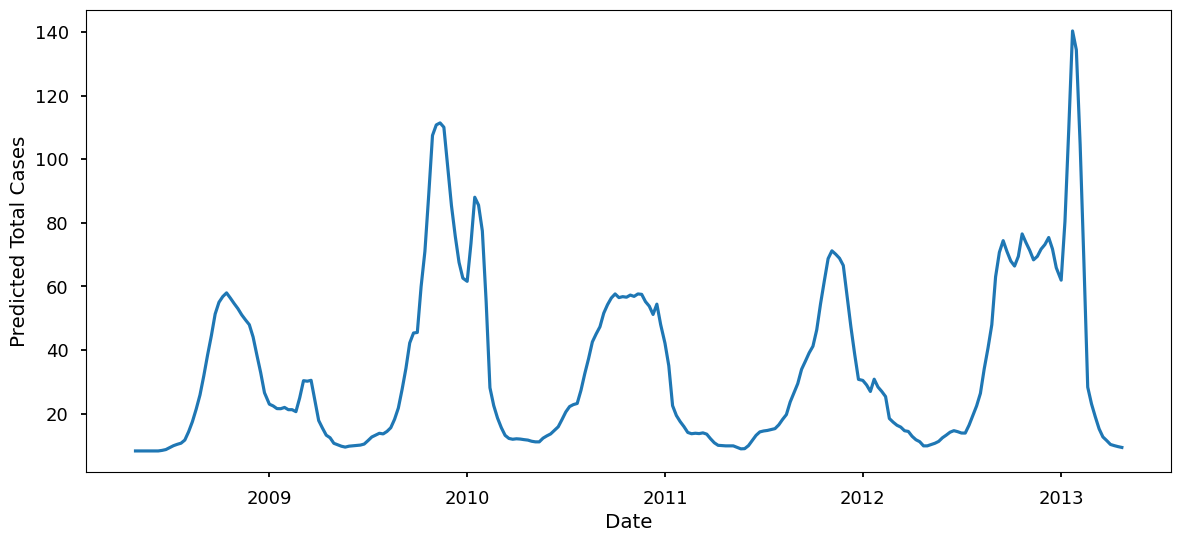

In [93]:
with plt.style.context('seaborn-talk'):
  fig, ax = plt.subplots(figsize=(14,6)) 
  ax.plot(predicted_test_final_rolled, label='test - forecasted') 
  ax.set_xlabel('Date')
  ax.set_ylabel('Predicted Total Cases')
  fig.patch.set_alpha(0) # make the figure background transparent
  # plt.tight_layout();
  fig.savefig('XGB_Forecast_Only.png', dpi=300, bbox_inches='tight')
  files.download("XGB_Forecast_Only.png") 

**Best permorning model predicts two more peaks by the end of years 2009 and 2012**

#### Visualize feature importance:

In [94]:
# Calculate Feature Importance
feature_importances = final_model.feature_importances_
importance = pd.Series(feature_importances, index=X_train_whole.columns) # always positive value?
importance.sort_values()

month                                             0.017704
station_avg_temp_c_shift_18                       0.041669
watery_shift_20                                   0.045804
reanalysis_precip_amt_kg_per_m2_shift_8           0.046078
reanalysis_tdtr_k_shift_8                         0.064036
grassy_shift_20                                   0.064926
soily_shift_20                                    0.108604
station_min_temp_c_shift_18                       0.148184
station_max_temp_c_shift_18                       0.192583
reanalysis_specific_humidity_g_per_kg_shift_12    0.270411
dtype: float32

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

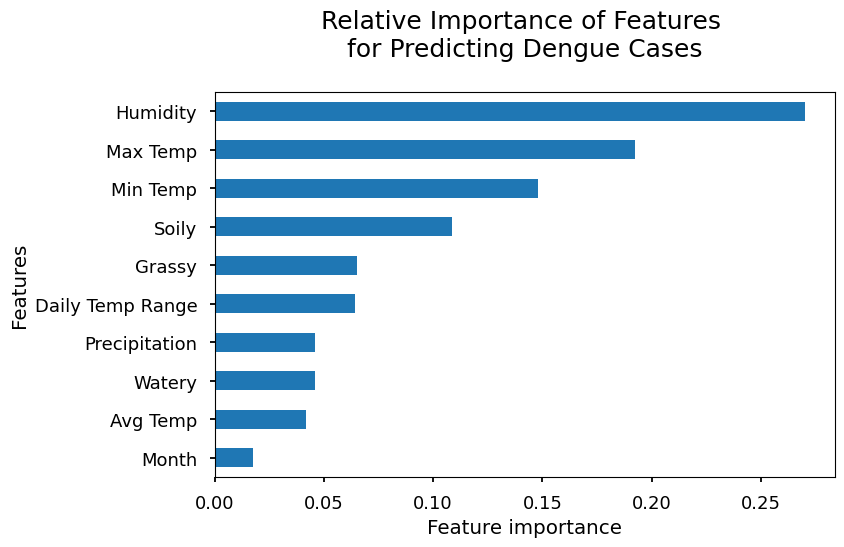

In [95]:
# Visualise Feature Importance
with plt.style.context('seaborn-talk'):
  fig, ax = plt.subplots(figsize=(8,5))
  importance.sort_values().plot.barh(ax=ax);
  ax.set_title("Relative Importance of Features \n for Predicting Dengue Cases \n", fontsize=18) 
  ax.set_xlabel('Feature importance')
  ax.set_ylabel('Features')
  ax.set_yticks([0,1,2,3,4,5,6,7,8,9])
  ax.set_yticklabels(['Month','Avg Temp','Watery','Precipitation','Daily Temp Range','Grassy', 'Soily','Min Temp','Max Temp','Humidity'])
  fig.patch.set_alpha(0) # make the figure background transparent
  # plt.tight_layout()
  fig.savefig('XGB_FeatureImportance.png', dpi=300, bbox_inches='tight')
  files.download("XGB_FeatureImportance.png")       

# LSTM Model # 1 Baseline

* You need an input shape of 3D tensor with shape (batch_size, timesteps, input_dim)

In [96]:
train_LSTM = train_final.copy()

In [97]:
train_LSTM1 = train_LSTM[['total_cases', 'month', 'station_max_temp_c', 'station_min_temp_c',
       'station_avg_temp_c', 'reanalysis_tdtr_k',
       'reanalysis_specific_humidity_g_per_kg',
       'reanalysis_precip_amt_kg_per_m2', 'grassy', 'soily',
       'watery']].copy()


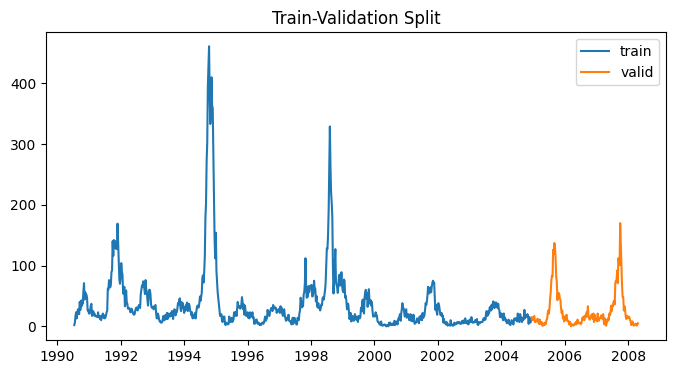

In [98]:
train = train_LSTM1.head(750)
test = train_LSTM1.tail(train_LSTM1.shape[0] - 750)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(train.total_cases, label='train')
ax.plot(test.total_cases, label='valid')
ax.set_title('Train-Validation Split')
plt.legend();

In [99]:
# the double brakets here are to keep the y in a dataframe format, otherwise it will be pandas Series
X_train, y_train = train.drop('total_cases', axis=1).copy(), train[['total_cases']].copy() 
X_test, y_test = test.drop('total_cases', axis=1).copy(), test[['total_cases']].copy() 

In [100]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((750, 10), (175, 10), (750, 1), (175, 1))

#### Scale and transform the data for neural network:

* Step 1: fit the scaler on the TRAINING data
* Step 2: use the scaler to transform the TRAINING data
* Step 3: use the transformed training data to fit the predictive model
* Step 4: use the scaler to transform the TEST data
* Step 5: predict using the trained modeland the transformed TEST data.

In [101]:
# scale X and y using the sklearn MinMaxScaler model, so that their range will be from 0 to 1.
Xscaler = MinMaxScaler(feature_range=(0, 1)) 
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
print(scaled_X_train.shape)

Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
print(scaled_y_train.shape)

# We need the shape of y to be (n, ), where n is the number of rows. 
# remove the second dimention from y so the shape changes from (n,1) to (n,)
scaled_y_train = scaled_y_train.reshape(-1)
print(scaled_y_train.shape)

# print(type(scaled_X_train))  # Making sure they are numpy arrays
# print(type(scaled_y_train)) 

(750, 10)
(750, 1)
(750,)


### Transform with TimeseriesGenerator:
* The TimeseriesGenerator transforms the separate X and y into a structure of samples ready to train deep learning models. 
*  The shape should be (batch_size,n_input,n_features)
* If batch size is equal to 3, the model will input the 3 sample videos and only after that 3 inputs, it will update the weights

In [102]:
# Create the train data
b_size = 32 #len(X_train)           # Number of timeseries samples in each batch
n_input = 12                        # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= scaled_X_train.shape[1] # how many predictors/Xs/features we have to predict y

train_generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

# The shape should be (batch_size,n_input,n_features)
print(train_generator[0][0].shape)

(32, 12, 10)


In [103]:
# Create the test data
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)
print(test_generator[0][0].shape)

(32, 12, 10)


## LSTM #1:
* Vanilla LSTM with a single hidden layer of LSTM units, and an output layer used to make a prediction.

In [104]:
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                840       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________


In [105]:
# Patience number of 10: the number of epochs to wait before early stop if no progress on the validation set. 
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [106]:
import random

In [107]:
# fit the model and plot the losses
def LSTM_fit_plotloss(train, test):
  random.seed(88) 
  model.fit(train, epochs=100, verbose = 0, validation_data=test, callbacks=[early_stop])
  loss_per_epoch = model.history.history['loss']
  val_loss_per_epoch = model.history.history['val_loss']
  plt.plot(range(len(loss_per_epoch)),loss_per_epoch, label = 'train_loss');
  plt.plot(range(len(val_loss_per_epoch)),val_loss_per_epoch, label = 'test_loss')
  plt.legend()

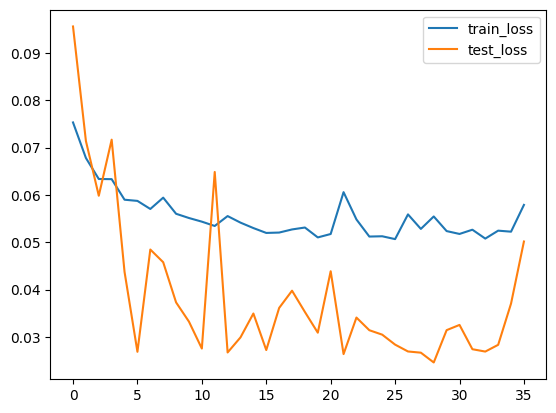

In [108]:
 LSTM_fit_plotloss(train_generator, test_generator)

* Now the model is ready to use and we can make predictions on the train and test set.

In [109]:
# Make predictions on train and test
y_train_pred_scaled = model.predict(train_generator)
y_train_pred = Yscaler.inverse_transform(y_train_pred_scaled)
train_prediction = pd.DataFrame({'y_true':y_train['total_cases'].values[n_input:],
                                'y_pred':y_train_pred.ravel()},
                                 index=y_train.index[n_input:])
  
y_test_pred_scaled = model.predict(test_generator)
y_test_pred = Yscaler.inverse_transform(y_test_pred_scaled)
test_prediction = pd.DataFrame({'y_true':y_test['total_cases'].values[n_input:],
                                  'y_pred':y_test_pred.ravel()},
                                 index=y_test.index[n_input:])

6/6 [==============================] - 0s 3ms/step


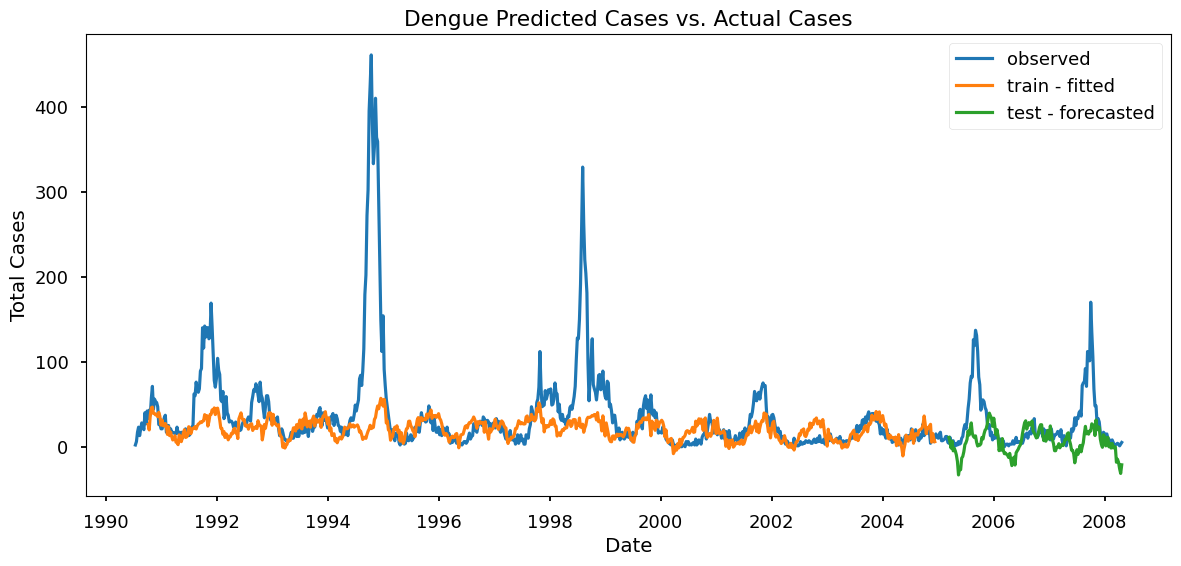

In [110]:
forecast_graph(train_LSTM.total_cases, train_prediction.y_pred, test_prediction.y_pred)

In [111]:
# Print the scores for both train and test
final_scores(train_prediction.y_true, train_prediction.y_pred, 
             test_prediction.y_true, test_prediction.y_pred)

MAE_train: 23.487685
MAE_test: 24.357151
-----------------------
RMSE_train: 55.053705
RMSE_test: 37.490538


**Summary:**

* The model captures the basic seasonality, while missing all the individual ourbreaks - peaks. 

## LSTM #2:
*  A deeper model

In [112]:
# instantiate the model

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(n_input, n_features), return_sequences=True)) # returns a sequence of vectors of dimension 64
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu', return_sequences=True)) # returns a sequence of vectors of dimension 32
model.add(Dropout(0.2))
model.add(LSTM(32)) # return a single vector of dimension 32
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 12, 128)           71168     
                                                                 
 dropout (Dropout)           (None, 12, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 12, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 12, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)               

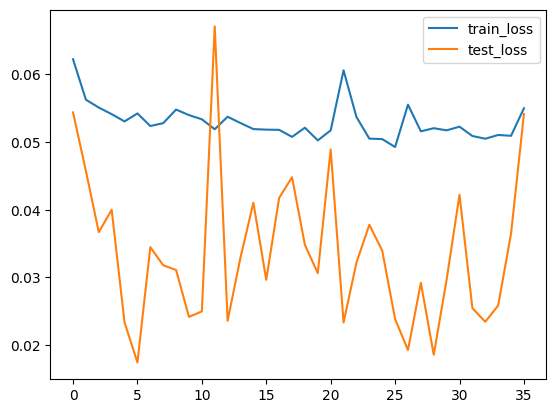

In [113]:
LSTM_fit_plotloss(train_generator, test_generator)

In [114]:
y_train_pred_scaled = model.predict(train_generator)
y_train_pred = Yscaler.inverse_transform(y_train_pred_scaled)
train_prediction = pd.DataFrame({'y_true':y_train['total_cases'].values[n_input:],
                                'y_pred':y_train_pred.ravel()},
                                 index=y_train.index[n_input:])
  
y_test_pred_scaled = model.predict(test_generator)
y_test_pred = Yscaler.inverse_transform(y_test_pred_scaled)
test_prediction = pd.DataFrame({'y_true':y_test['total_cases'].values[n_input:],
                                  'y_pred':y_test_pred.ravel()},
                                 index=y_test.index[n_input:])

6/6 [==============================] - 0s 13ms/step


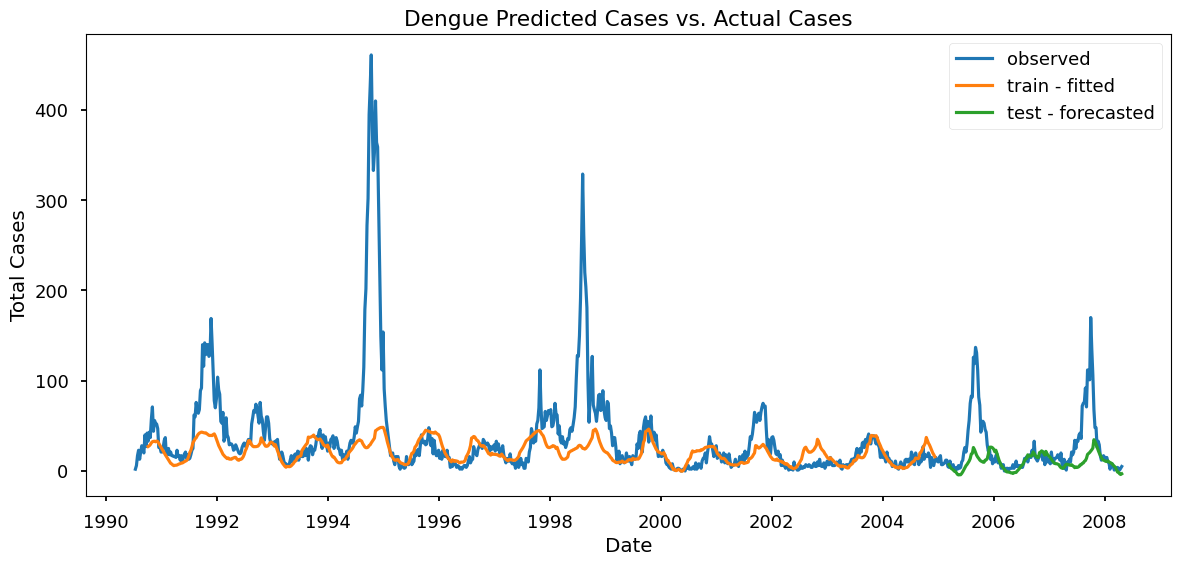

In [115]:
forecast_graph(train_LSTM1.total_cases, train_prediction.y_pred, test_prediction.y_pred)

In [116]:
final_scores(train_prediction.y_true, train_prediction.y_pred, test_prediction.y_true, test_prediction.y_pred)

MAE_train: 22.158431
MAE_test: 18.757234
-----------------------
RMSE_train: 53.612466
RMSE_test: 33.965146


**Summary:**

* Increasing complexity was not enough to for the model to detect peaks /outbreaks. 

## LSTM #3
* Lagged variables with a deeper model

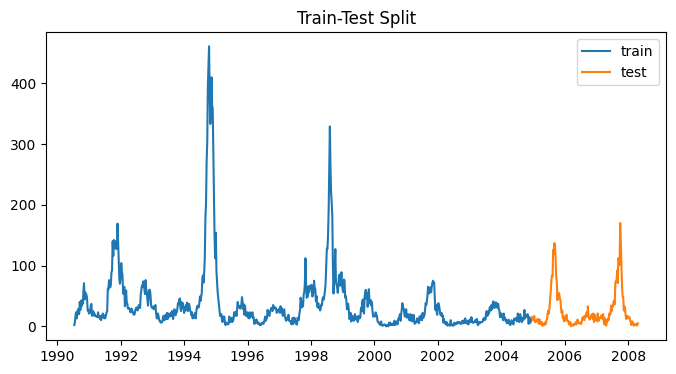

In [117]:
train_LSTM3 = train_LSTM[['total_cases', 'month',
                          'station_max_temp_c_shift_18', 'station_min_temp_c_shift_18',
                          'station_avg_temp_c_shift_18', 'reanalysis_tdtr_k_shift_8','reanalysis_specific_humidity_g_per_kg_shift_12',
                          'reanalysis_precip_amt_kg_per_m2_shift_8', 'soily_shift_20', 'grassy_shift_20',
                          'watery_shift_20']].copy()

train_data = train_LSTM3.head(750)
test_data = train_LSTM3.tail(train_LSTM3.shape[0] - 750)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(train_data.total_cases, label='train')
ax.plot(test_data.total_cases, label='test')
ax.set_title('Train-Test Split');
plt.legend()

X_train, y_train = train_data.drop('total_cases', axis=1).copy(), train_data[['total_cases']].copy() 
X_test, y_test = test_data.drop('total_cases', axis=1).copy(), test_data[['total_cases']].copy() 

In [118]:
# scale X and y using the sklearn MinMaxScaler model, so that their range will be from 0 to 1.
Xscaler = MinMaxScaler(feature_range=(0, 1)) 
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
print(scaled_X_train.shape)

Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
print(scaled_y_train.shape)

# We need the shape of y to be (n, ), where n is the number of rows. 
# remove the second dimention from y so the shape changes from (n,1) to (n,)
scaled_y_train = scaled_y_train.reshape(-1)
print(scaled_y_train.shape)


(750, 10)
(750, 1)
(750,)


In [119]:
b_size = 32                         # len(X_train) Number of timeseries samples in each batch
n_input = 12                        # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= scaled_X_train.shape[1] # how many predictors/Xs/features we have to predict y

train_generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

# The shape should be (batch_size,n_input,n_features)
print(train_generator[0][0].shape)

(32, 12, 10)


In [120]:
# create the validation data
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)
print(test_generator[0][0].shape)

(32, 12, 10)


In [121]:
model = Sequential()
model.add(LSTM(512, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu', return_sequences=True)) # returns a sequence of vectors of dimension 64
model.add(Dropout(0.2))
model.add(LSTM(32)) # return a single vector of dimension 32
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 12, 512)           1071104   
                                                                 
 dropout_4 (Dropout)         (None, 12, 512)           0         
                                                                 
 lstm_5 (LSTM)               (None, 12, 256)           787456    
                                                                 
 dropout_5 (Dropout)         (None, 12, 256)           0         
                                                                 
 lstm_6 (LSTM)               (None, 12, 128)           197120    
                                                                 
 dropout_6 (Dropout)         (None, 12, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 12, 64)           

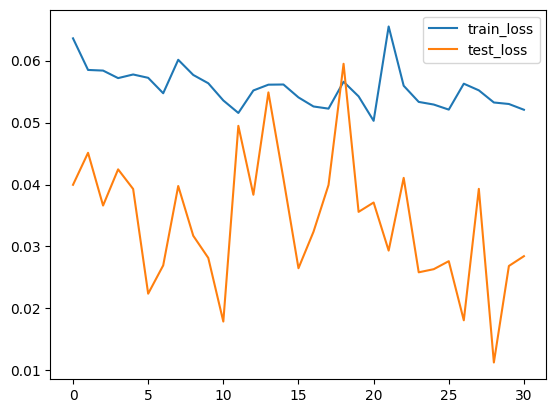

In [122]:
# fit the model and plot the losses
LSTM_fit_plotloss(train_generator, test_generator)

In [123]:
y_train_pred_scaled = model.predict(train_generator)
y_train_pred = Yscaler.inverse_transform(y_train_pred_scaled)
train_prediction = pd.DataFrame({'y_true':y_train['total_cases'].values[n_input:],
                                'y_pred':y_train_pred.ravel()},
                                 index=y_train.index[n_input:])
  
y_test_pred_scaled = model.predict(test_generator)
y_test_pred = Yscaler.inverse_transform(y_test_pred_scaled)
test_prediction = pd.DataFrame({'y_true':y_test['total_cases'].values[n_input:],
                                  'y_pred':y_test_pred.ravel()},
                                 index=y_test.index[n_input:])

6/6 [==============================] - 0s 47ms/step


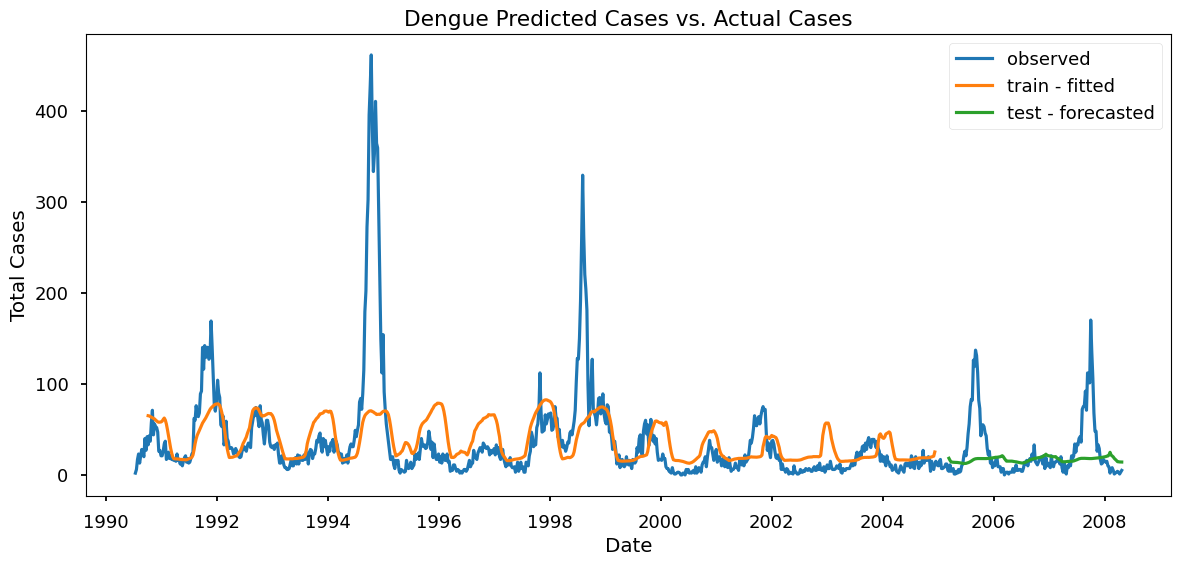

In [124]:
forecast_graph(train_LSTM.total_cases, train_prediction['y_pred'], test_prediction['y_pred'])

In [125]:
final_scores(train_prediction.y_true, train_prediction.y_pred, test_prediction.y_true, test_prediction.y_pred)

MAE_train: 24.939471
MAE_test: 20.086405
-----------------------
RMSE_train: 49.072102
RMSE_test: 34.142427


**Summary:**

* Using the lagged variables with increased complexity improved the model slightly but it is still unable to detect individual peaks/outbreaks.  

### Export as PDF:

In [126]:
# Packages required for using nbconvert PDF
# ! apt-get install texlive texlive-xetex texlive-latex-extra pandoc
# ! pip install pypandoc
# ! pip install nbconvert

In [127]:
# First you need to download a copy of the ipynb notebook and upload it back to the drive, it is placed under /content/
# ! jupyter nbconvert --to pdf /content/notebook_preprocessing.ipynb